# Spark Streaming: frecuencia de tweets

Cayetano Rodríguez Medina

Primero hay que importar el contexto de Spark y configurarlo. Le ponemos un nombre a la aplicación y especificamos cuál es el master de Spark al que nos queremos conectar.

In [1]:
from pyspark import SparkContext
from pyspark import SparkConf
conf = SparkConf().setAppName("streaming").setMaster("spark://tfmspark.ddns.net:7077")
sc = SparkContext.getOrCreate(conf=conf)

A continuación añadimos una serie de imports necesarios para realizar el streaming. 

In [2]:
# Spark Streaming
from pyspark.streaming import StreamingContext  
# Kafka
from pyspark.streaming.kafka import KafkaUtils

Creamos el contexto para el módulo de Spark Streaming, usando el contexto de Spark. El segundo parámetro es el intervalo de lote en segundos.

In [3]:
ssc = StreamingContext(sc, 60)  
ssc.checkpoint('/tmp/checkpoint_v03')

Una vez tenemos el contexto creado, podemos inicializar el streaming a partir de Kafka. Para ello, nos conectaremos al servidor de Zookeper deseado, y leeremos el topic 'twitter'. En el otro lado se encuentra una aplicación consumiendo tweets en streaming, que se van introduciendo en la cola Kafka para ser ingeridos por Spark.

In [4]:
zookeper = 'tfmkafka.ddns.net:2181'
kafkaStream = KafkaUtils.createStream(ssc, zookeper, 'spark-streaming',topics={'twitter':1})

Del flujo recibido, nos quedamos con la segunda componente, que es la que contiene los datos de Kafka.

In [5]:
tweet_dates = kafkaStream.map(lambda x: x[1].split("|")[0])
tweet_users = kafkaStream.map(lambda x: x[1].split("|")[1])

Vamos a definir una función a la que se llamará posteriormente para escribir los datos en un fichero de texto.

In [6]:
def write_dates (line):
    f = open('dates.txt', 'w')
    f.write(line + '\n')

Las siguientes líneas son las que se ejecutarán durante el streaming de Spark. En primer lugar se imprime un extracto de los datos recibidos por cada lote, y a continuación se escribe en el fichero de texto cada una de los elementos de cada RDD del flujo.

In [7]:
# Count tweets in this batch
ntweets = kafkaStream.count()
ntweets.map(lambda x: "Number of tweets this batch: %s" % x).pprint()

# Print all dates in this batch
tweet_dates.pprint()
# Save tweet dates to a file to process it later
tweet_dates.foreachRDD(lambda x: x.foreach(lambda y: write_dates(y)))

# Print all users in this batch
tweet_users.pprint()

import matplotlib.pyplot as plt

def updateFunc(newValues, lastSum):
    if lastSum is None:
        lastSum = 0
    result = sum(newValues, lastSum)

    return result

# Let's count tweet by each user in all the streaming using updateStateByKey function
count = tweet_users.countByValue().updateStateByKey(updateFunc)
# Now we sort this users to get the top five
sortedCount = count.transform(lambda rdd: rdd.sortBy(lambda x: -x[1]))
sortedCount.pprint(5)


# This function is used to print a pie chart showing the 5 most active users
def activeUsers (rdd):
    # Convert RDD to dictionary
    diction = rdd.collectAsMap()
    # Sort list by number of tweets
    sortedList = sorted(diction.items(), key=lambda x: x[1], reverse=True)
    # Create pie chart to show the 5 most active users
    if (len(sortedList) >= 5):
        labels = sortedList[0][0], sortedList[1][0], sortedList[2][0], sortedList[3][0], sortedList[4][0]
        values = [sortedList[0][1], sortedList[1][1], sortedList[2][1], sortedList[3][1], sortedList[4][1]]
        colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', "#96624E"]
        explode = (0.1, 0, 0, 0, 0)  # explode 1st slice
        
        plt.pie(values, explode = explode, labels = labels, colors = colors, autopct='%1.1f%%', shadow=True, startangle=140)
        plt.axis('equal')
        plt.show()

# Now we call this function for each RDD in the DStream
sortedCount.foreachRDD(lambda x: activeUsers(x))

Finalmente, comenzamos a recibir datos y procesarlos, y esperamos a que termine el procesamiento.

-------------------------------------------
Time: 2017-04-30 11:46:00
-------------------------------------------
Number of tweets this batch: 11

-------------------------------------------
Time: 2017-04-30 11:46:00
-------------------------------------------
2017-04-30 11:44:52
2017-04-30 11:44:52
2017-04-30 11:44:52
2017-04-30 11:44:52
2017-04-30 11:44:54
2017-04-30 11:44:54
2017-04-30 11:44:54
2017-04-30 11:44:54
2017-04-30 11:44:54
2017-04-30 11:44:55
...

-------------------------------------------
Time: 2017-04-30 11:46:00
-------------------------------------------
StephLuvsSports
LucianoYoma
tweety_re
Tatsuyachan3z
tweety_re
candleclub1
autohebdo
RUBENM98
StSchererZhou
Gerardos92
...

-------------------------------------------
Time: 2017-04-30 11:46:00
-------------------------------------------
('tweety_re', 2)
('RUBENM98', 1)
('StephLuvsSports', 1)
('StSchererZhou', 1)
('autohebdo', 1)
...



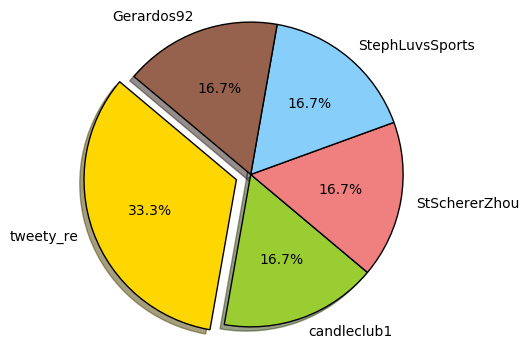

-------------------------------------------
Time: 2017-04-30 11:47:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 11:47:00
-------------------------------------------
2017-04-30 11:44:55
2017-04-30 11:44:55
2017-04-30 11:44:56
2017-04-30 11:44:56
2017-04-30 11:44:56
2017-04-30 11:44:56
2017-04-30 11:44:57
2017-04-30 11:44:58
2017-04-30 11:44:58
2017-04-30 11:44:58
...

-------------------------------------------
Time: 2017-04-30 11:47:00
-------------------------------------------
BritishPKMN1991
miyake9
22Yochan
charlyscott237
Kevinkgpk
coatajp
ZiggoSportF1
mdLouisa
twpope
MonacoF1Karting
...

-------------------------------------------
Time: 2017-04-30 11:47:00
-------------------------------------------
('tweety_re', 2)
('miyake9', 1)
('StephLuvsSports', 1)
('RUBENM98', 1)
('charlyscott237', 1)
...



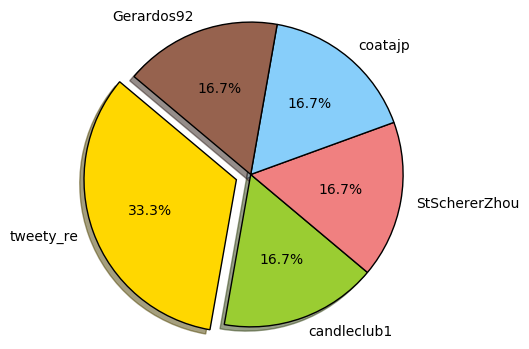

-------------------------------------------
Time: 2017-04-30 11:48:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 11:48:00
-------------------------------------------
2017-04-30 11:44:59
2017-04-30 11:44:59
2017-04-30 11:44:59
2017-04-30 11:45:00
2017-04-30 11:44:59
2017-04-30 11:45:00
2017-04-30 11:45:00
2017-04-30 11:45:00
2017-04-30 11:45:01
2017-04-30 11:45:01
...

-------------------------------------------
Time: 2017-04-30 11:48:00
-------------------------------------------
rigorondon2017
Takashiw0lf
streethawk70
F1_Daniel5
TeamHulkenberg
JPSBlackSirius
SBOBET
tweety_re
HouseCracka
JasonHarry40
...

-------------------------------------------
Time: 2017-04-30 11:48:00
-------------------------------------------
('tweety_re', 3)
('miyake9', 1)
('streethawk70', 1)
('JPSBlackSirius', 1)
('rigorondon2017', 1)
...



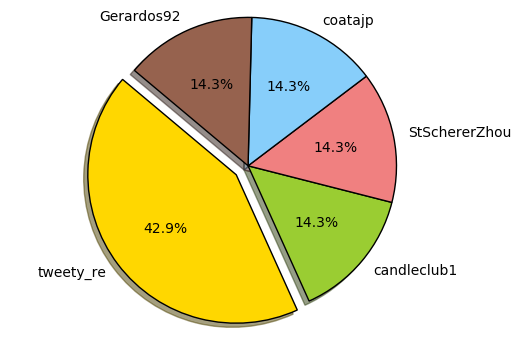

-------------------------------------------
Time: 2017-04-30 11:49:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 11:49:00
-------------------------------------------
2017-04-30 11:45:00
2017-04-30 11:45:01
2017-04-30 11:45:02
2017-04-30 11:45:02
2017-04-30 11:45:03
2017-04-30 11:45:01
2017-04-30 11:45:03
2017-04-30 11:45:03
2017-04-30 11:45:03
2017-04-30 11:45:04
...

-------------------------------------------
Time: 2017-04-30 11:49:00
-------------------------------------------
TelegraphSport
Zainab_Pharm
F1_Madness
Formula1_MotoGP
mandyhendriks
RenaultBrasil
tweety_re
Hacchan75
Suhikuwohite
itisme_Patty
...

-------------------------------------------
Time: 2017-04-30 11:49:00
-------------------------------------------
('tweety_re', 4)
('12cMac', 1)
('F1_Madness', 1)
('joecaputo', 1)
('Hacchan75', 1)
...



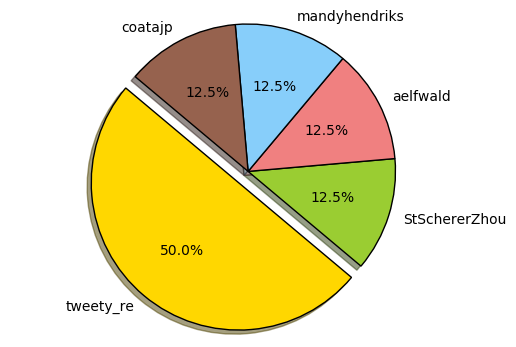

-------------------------------------------
Time: 2017-04-30 11:50:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 11:50:00
-------------------------------------------
2017-04-30 11:45:04
2017-04-30 11:45:05
2017-04-30 11:45:05
2017-04-30 11:45:05
2017-04-30 11:45:06
2017-04-30 11:45:06
2017-04-30 11:45:06
2017-04-30 11:45:07
2017-04-30 11:45:07
2017-04-30 11:45:07
...

-------------------------------------------
Time: 2017-04-30 11:50:00
-------------------------------------------
SoyMotor
KR7even
pan_amanuel
InocuidadyVida
zig27
StevenSportNews
Gary_Sama
gaypalace
otikenne
vashcoold
...

-------------------------------------------
Time: 2017-04-30 11:50:00
-------------------------------------------
('tweety_re', 4)
('zig27', 1)
('12cMac', 1)
('F1_Madness', 1)
('joecaputo', 1)
...



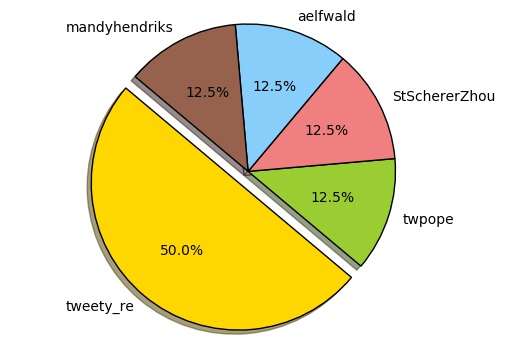

-------------------------------------------
Time: 2017-04-30 11:51:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 11:51:00
-------------------------------------------
2017-04-30 11:45:07
2017-04-30 11:45:08
2017-04-30 11:45:08
2017-04-30 11:45:08
2017-04-30 11:45:08
2017-04-30 11:45:09
2017-04-30 11:45:09
2017-04-30 11:45:10
2017-04-30 11:45:10
2017-04-30 11:45:10
...

-------------------------------------------
Time: 2017-04-30 11:51:00
-------------------------------------------
marceldeneef
bananacion
JPN_MS
likeF1
BetFastBTC
salmanabilaarr
markinapub
Capn_Cody
Hulab0y
Iceman_A3
...

-------------------------------------------
Time: 2017-04-30 11:51:00
-------------------------------------------
('tweety_re', 4)
('marceldeneef', 1)
('zig27', 1)
('12cMac', 1)
('F1_Madness', 1)
...



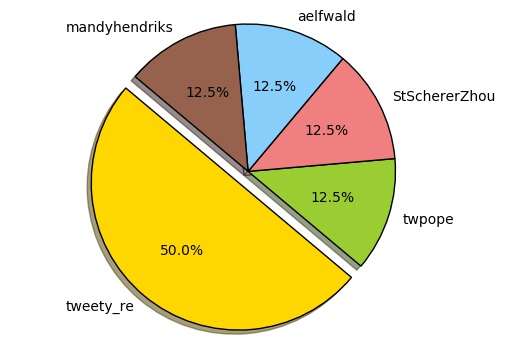

-------------------------------------------
Time: 2017-04-30 11:52:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 11:52:00
-------------------------------------------
2017-04-30 11:45:10
2017-04-30 11:45:10
2017-04-30 11:45:10
2017-04-30 11:45:11
2017-04-30 11:45:11
2017-04-30 11:45:12
2017-04-30 11:45:12
2017-04-30 11:45:11
2017-04-30 11:45:12
2017-04-30 11:45:13
...

-------------------------------------------
Time: 2017-04-30 11:52:00
-------------------------------------------
HeikSiitari
CTVGER
joecaputo
sigaoneto
f1fanatic_co_uk
tweety_re
bigpicguy
ESPNF1
b_lorranyap
fanny_garces20
...

-------------------------------------------
Time: 2017-04-30 11:52:00
-------------------------------------------
('tweety_re', 5)
('joecaputo', 2)
('marceldeneef', 1)
('streethawk70', 1)
('fanny_garces20', 1)
...



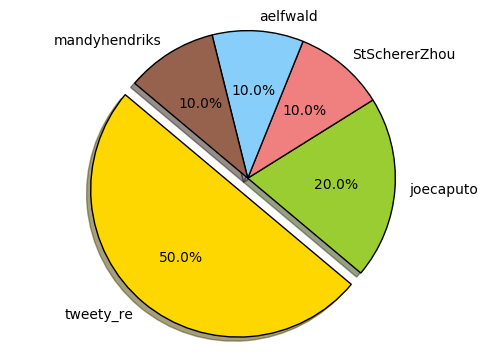

-------------------------------------------
Time: 2017-04-30 11:53:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 11:53:00
-------------------------------------------
2017-04-30 11:45:13
2017-04-30 11:45:13
2017-04-30 11:45:14
2017-04-30 11:45:14
2017-04-30 11:45:14
2017-04-30 11:45:14
2017-04-30 11:45:14
2017-04-30 11:45:15
2017-04-30 11:45:15
2017-04-30 11:45:15
...

-------------------------------------------
Time: 2017-04-30 11:53:00
-------------------------------------------
krisracing
MotorsportWeek
joecaputo
HouseCracka
joecaputo
tweety_re
Dina_Gvozdeva
LucianoYoma
lishalozada
TheAshokSingh
...

-------------------------------------------
Time: 2017-04-30 11:53:00
-------------------------------------------
('tweety_re', 6)
('joecaputo', 4)
('HouseCracka', 2)
('LucianoYoma', 2)
('marceldeneef', 1)
...



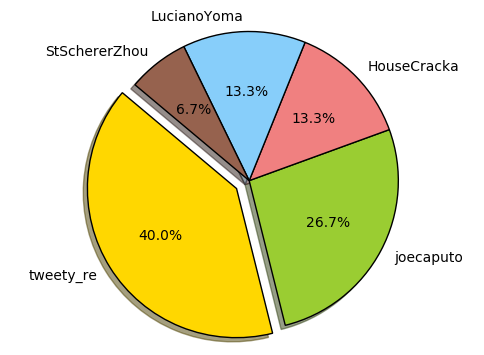

-------------------------------------------
Time: 2017-04-30 11:54:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 11:54:00
-------------------------------------------
2017-04-30 11:45:16
2017-04-30 11:45:16
2017-04-30 11:45:16
2017-04-30 11:45:16
2017-04-30 11:45:16
2017-04-30 11:45:16
2017-04-30 11:45:17
2017-04-30 11:45:17
2017-04-30 11:45:17
2017-04-30 11:45:17
...

-------------------------------------------
Time: 2017-04-30 11:54:00
-------------------------------------------
xAngryclaws
LisaPatten1
bowy_john
Saetta_McQueen
laurencemoar
quaranta_vito
Cleared_Wright
Vir7anen
Chrisovglyn14
F1NewsHQ
...

-------------------------------------------
Time: 2017-04-30 11:54:00
-------------------------------------------
('tweety_re', 6)
('joecaputo', 4)
('HouseCracka', 2)
('LucianoYoma', 2)
('marceldeneef', 1)
...



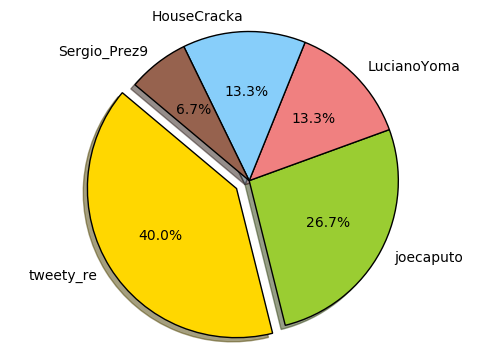

-------------------------------------------
Time: 2017-04-30 11:55:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 11:55:00
-------------------------------------------
2017-04-30 11:45:19
2017-04-30 11:45:20
2017-04-30 11:45:20
2017-04-30 11:45:19
2017-04-30 11:45:20
2017-04-30 11:45:20
2017-04-30 11:45:21
2017-04-30 11:45:21
2017-04-30 11:45:21
2017-04-30 11:45:22
...

-------------------------------------------
Time: 2017-04-30 11:55:00
-------------------------------------------
lauriky78
gianlucas71
Hardieboy76
lewisglynn69
RichardBrandNL
24usamaru
MicheleTrotta5
Mr_AlVil
salmanabilaarr
Caniel1603
...

-------------------------------------------
Time: 2017-04-30 11:55:00
-------------------------------------------
('tweety_re', 6)
('joecaputo', 4)
('rigorondon2017', 2)
('HouseCracka', 2)
('salmanabilaarr', 2)
...



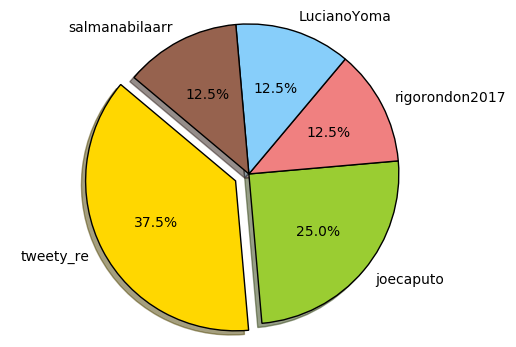

-------------------------------------------
Time: 2017-04-30 11:56:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 11:56:00
-------------------------------------------
2017-04-30 11:45:23
2017-04-30 11:45:22
2017-04-30 11:45:22
2017-04-30 11:45:23
2017-04-30 11:45:24
2017-04-30 11:45:24
2017-04-30 11:45:24
2017-04-30 11:45:24
2017-04-30 11:45:24
2017-04-30 11:45:25
...

-------------------------------------------
Time: 2017-04-30 11:56:00
-------------------------------------------
jtrawczynski
nohita
kimi443mika
Aya_Shaker
ehitroian
exclusivracing
Formula1WM
MganeGarnier
AJV1Beta
LastWordOnF1
...

-------------------------------------------
Time: 2017-04-30 11:56:00
-------------------------------------------
('tweety_re', 6)
('joecaputo', 4)
('rigorondon2017', 2)
('HouseCracka', 2)
('salmanabilaarr', 2)
...



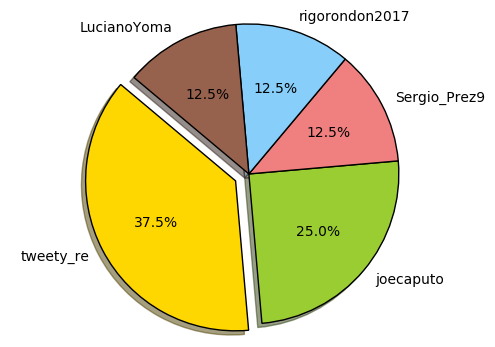

-------------------------------------------
Time: 2017-04-30 11:57:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 11:57:00
-------------------------------------------
2017-04-30 11:45:25
2017-04-30 11:45:26
2017-04-30 11:45:27
2017-04-30 11:45:27
2017-04-30 11:45:27
2017-04-30 11:45:27
2017-04-30 11:45:27
2017-04-30 11:45:27
2017-04-30 11:45:28
2017-04-30 11:45:28
...

-------------------------------------------
Time: 2017-04-30 11:57:00
-------------------------------------------
Formula1WM
f143210
ARulamo
BonzoMassimo
sergiosillas19
Formula1WM
tyyyyypk1ch
enrico_pirina
HouseCracka
itsyoboyello
...

-------------------------------------------
Time: 2017-04-30 11:57:00
-------------------------------------------
('tweety_re', 6)
('joecaputo', 4)
('Formula1WM', 4)
('HouseCracka', 3)
('rigorondon2017', 2)
...



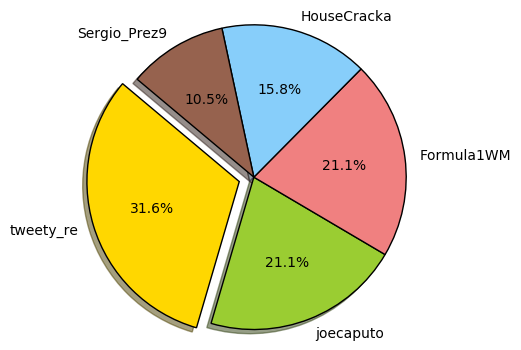

-------------------------------------------
Time: 2017-04-30 11:58:00
-------------------------------------------
Number of tweets this batch: 5

-------------------------------------------
Time: 2017-04-30 11:58:00
-------------------------------------------
2017-04-30 11:45:28
2017-04-30 11:45:29
2017-04-30 11:45:28
2017-04-30 11:45:29
2017-04-30 11:45:29

-------------------------------------------
Time: 2017-04-30 11:58:00
-------------------------------------------
Formula1WM
formulaonevault
barungi8
archatoz
FareedR_

-------------------------------------------
Time: 2017-04-30 11:58:00
-------------------------------------------
('tweety_re', 6)
('Formula1WM', 5)
('joecaputo', 4)
('HouseCracka', 3)
('rigorondon2017', 2)
...



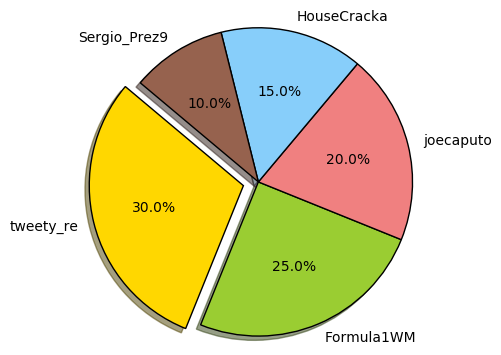

-------------------------------------------
Time: 2017-04-30 11:59:00
-------------------------------------------
Number of tweets this batch: 4

-------------------------------------------
Time: 2017-04-30 11:59:00
-------------------------------------------
2017-04-30 11:58:40
2017-04-30 11:58:41
2017-04-30 11:58:41
2017-04-30 11:58:41

-------------------------------------------
Time: 2017-04-30 11:59:00
-------------------------------------------
iambrunodelima
Peercys2
antonio_m_reed
ConorBuller

-------------------------------------------
Time: 2017-04-30 11:59:00
-------------------------------------------
('tweety_re', 6)
('Formula1WM', 5)
('joecaputo', 4)
('HouseCracka', 3)
('rigorondon2017', 2)
...



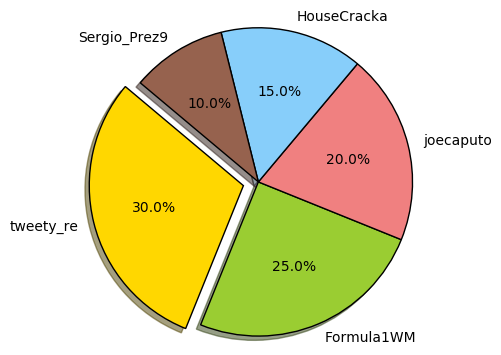

-------------------------------------------
Time: 2017-04-30 12:00:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:00:00
-------------------------------------------
2017-04-30 11:58:41
2017-04-30 11:58:41
2017-04-30 11:58:41
2017-04-30 11:58:41
2017-04-30 11:58:41
2017-04-30 11:58:41
2017-04-30 11:58:41
2017-04-30 11:58:42
2017-04-30 11:58:42
2017-04-30 11:58:42
...

-------------------------------------------
Time: 2017-04-30 12:00:00
-------------------------------------------
rigorondon2017
tarsopaulo
kinjorge
Victorodu
brendakodawa
rubenike_94
Shinnawi96
ElliotHorwoodF1
spacebearpirate
ojioji_m
...

-------------------------------------------
Time: 2017-04-30 12:00:00
-------------------------------------------
('tweety_re', 6)
('Formula1WM', 5)
('joecaputo', 4)
('rigorondon2017', 3)
('HouseCracka', 3)
...



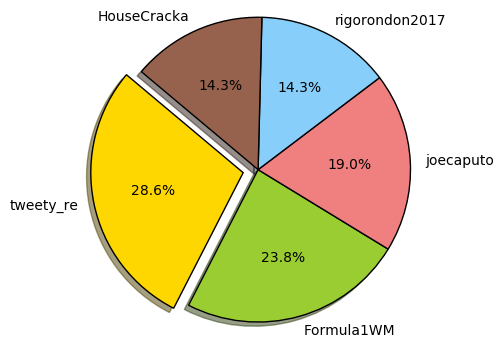

-------------------------------------------
Time: 2017-04-30 12:01:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:01:00
-------------------------------------------
2017-04-30 11:58:42
2017-04-30 11:58:42
2017-04-30 11:58:43
2017-04-30 11:58:43
2017-04-30 11:58:43
2017-04-30 11:58:43
2017-04-30 11:58:44
2017-04-30 11:58:44
2017-04-30 11:58:44
2017-04-30 11:58:44
...

-------------------------------------------
Time: 2017-04-30 12:01:00
-------------------------------------------
andradefabioo
novus_discipula
wullie_c
england3221
labzyl
0mimamoruyo0
OgoneMorake
forf1ssake
RichMsonthi
anx_sampinx
...

-------------------------------------------
Time: 2017-04-30 12:01:00
-------------------------------------------
('tweety_re', 6)
('Formula1WM', 5)
('joecaputo', 4)
('rigorondon2017', 3)
('HouseCracka', 3)
...



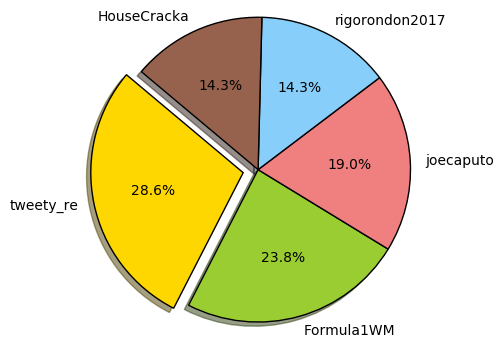

-------------------------------------------
Time: 2017-04-30 12:02:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:02:00
-------------------------------------------
2017-04-30 11:58:45
2017-04-30 11:58:45
2017-04-30 11:58:45
2017-04-30 11:58:45
2017-04-30 11:58:45
2017-04-30 11:58:45
2017-04-30 11:58:45
2017-04-30 11:58:45
2017-04-30 11:58:45
2017-04-30 11:58:45
...

-------------------------------------------
Time: 2017-04-30 12:02:00
-------------------------------------------
karan13dewan
ylipeju
GlenDoc
geyan_com
Bored_thriller
Vishalsahani18
LastWordOnF1
shah_323
joecaputo
ferenckovacs
...

-------------------------------------------
Time: 2017-04-30 12:02:00
-------------------------------------------
('tweety_re', 6)
('joecaputo', 5)
('Formula1WM', 5)
('rigorondon2017', 3)
('HouseCracka', 3)
...



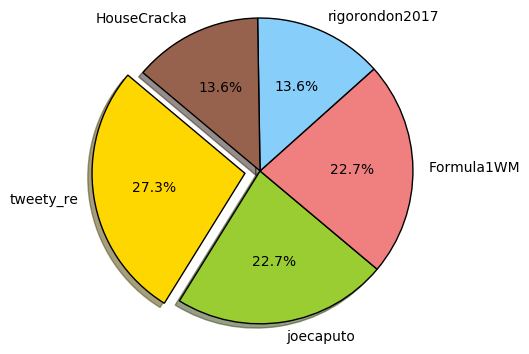

-------------------------------------------
Time: 2017-04-30 12:03:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:03:00
-------------------------------------------
2017-04-30 11:58:45
2017-04-30 11:58:46
2017-04-30 11:58:46
2017-04-30 11:58:46
2017-04-30 11:58:46
2017-04-30 11:58:46
2017-04-30 11:58:46
2017-04-30 11:58:47
2017-04-30 11:58:47
2017-04-30 11:58:47
...

-------------------------------------------
Time: 2017-04-30 12:03:00
-------------------------------------------
ShanesiaEpoh
Eduardo_2983
LaChicaF1_
mcrisever
FernandoDupuy
moronmutiny
exclusivracing
DaHero_
IIalfreII
AlanRamrez3
...

-------------------------------------------
Time: 2017-04-30 12:03:00
-------------------------------------------
('tweety_re', 6)
('joecaputo', 5)
('Formula1WM', 5)
('rigorondon2017', 3)
('HouseCracka', 3)
...



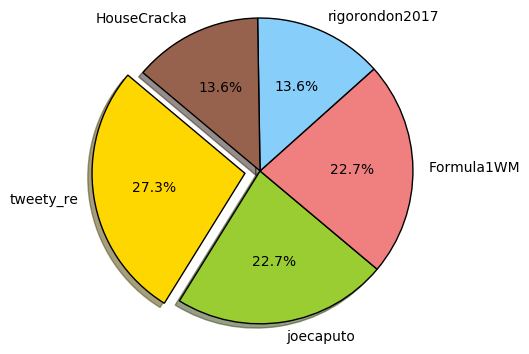

-------------------------------------------
Time: 2017-04-30 12:04:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:04:00
-------------------------------------------
2017-04-30 11:58:47
2017-04-30 11:58:47
2017-04-30 11:58:48
2017-04-30 11:58:48
2017-04-30 11:58:48
2017-04-30 11:58:48
2017-04-30 11:58:48
2017-04-30 11:58:48
2017-04-30 11:58:49
2017-04-30 11:58:49
...

-------------------------------------------
Time: 2017-04-30 12:04:00
-------------------------------------------
Formula1chick
joecaputo
bill_101_bob
EmiDicharri111
juniorsanq
TheF1Joker
the_HB_Qartel
PatatoOor
0mimamoruyo0
losferson
...

-------------------------------------------
Time: 2017-04-30 12:04:00
-------------------------------------------
('joecaputo', 6)
('tweety_re', 6)
('Formula1WM', 5)
('rigorondon2017', 3)
('HouseCracka', 3)
...



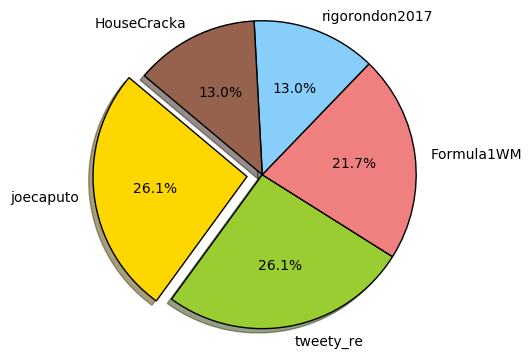

-------------------------------------------
Time: 2017-04-30 12:05:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:05:00
-------------------------------------------
2017-04-30 11:58:49
2017-04-30 11:58:49
2017-04-30 11:58:49
2017-04-30 11:58:49
2017-04-30 11:58:50
2017-04-30 11:58:50
2017-04-30 11:58:50
2017-04-30 11:58:50
2017-04-30 11:58:50
2017-04-30 11:58:51
...

-------------------------------------------
Time: 2017-04-30 12:05:00
-------------------------------------------
zpscissors
mokayaorina
Nadia90Nice
CautionClock20
Athreya51
JabaPloc
LUISFELIPESU
Bettina9898
LadyVettel
LiveGPit
...

-------------------------------------------
Time: 2017-04-30 12:05:00
-------------------------------------------
('joecaputo', 6)
('tweety_re', 6)
('Formula1WM', 5)
('rigorondon2017', 3)
('HouseCracka', 3)
...



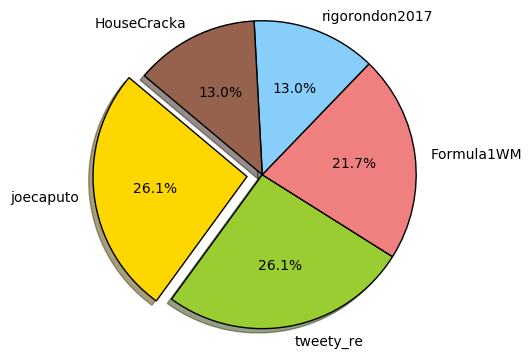

-------------------------------------------
Time: 2017-04-30 12:06:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:06:00
-------------------------------------------
2017-04-30 11:58:51
2017-04-30 11:58:51
2017-04-30 11:58:52
2017-04-30 11:58:52
2017-04-30 11:58:52
2017-04-30 11:58:52
2017-04-30 11:58:52
2017-04-30 11:58:52
2017-04-30 11:58:52
2017-04-30 11:58:52
...

-------------------------------------------
Time: 2017-04-30 12:06:00
-------------------------------------------
samuele_panzeri
Guillaumemp
aswinprasetyo
BetterThanMe
ALasbarreres
14Wade
mcnallyc95
ReifZahl
Jeremy_lsf
piyo10AR
...

-------------------------------------------
Time: 2017-04-30 12:06:00
-------------------------------------------
('joecaputo', 6)
('tweety_re', 6)
('Formula1WM', 5)
('rigorondon2017', 3)
('HouseCracka', 3)
...



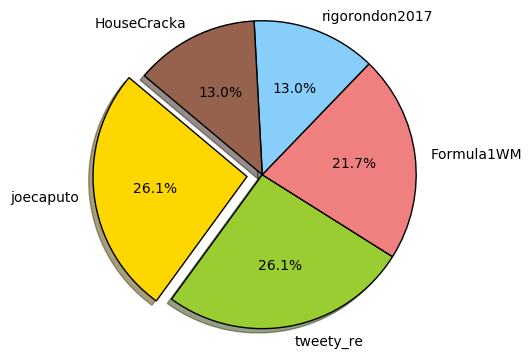

-------------------------------------------
Time: 2017-04-30 12:07:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:07:00
-------------------------------------------
2017-04-30 11:58:53
2017-04-30 11:58:53
2017-04-30 11:58:53
2017-04-30 11:58:53
2017-04-30 11:58:53
2017-04-30 11:58:53
2017-04-30 11:58:54
2017-04-30 11:58:54
2017-04-30 11:58:54
2017-04-30 11:58:54
...

-------------------------------------------
Time: 2017-04-30 12:07:00
-------------------------------------------
Eliaslauda
exclusivracing
cicciopalu
0mimamoruyo0
cmcgato
queridoseb
hardworkwinz
mcrisever
ddawgsports
LeonelHibl
...

-------------------------------------------
Time: 2017-04-30 12:07:00
-------------------------------------------
('joecaputo', 6)
('tweety_re', 6)
('Formula1WM', 5)
('rigorondon2017', 3)
('0mimamoruyo0', 3)
...



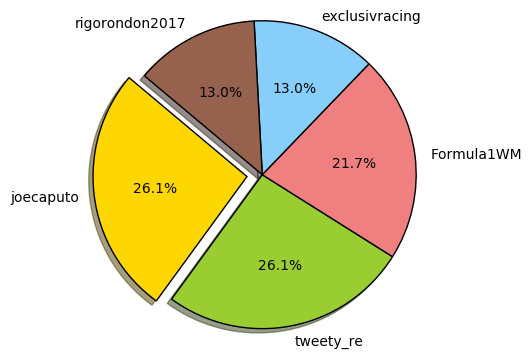

-------------------------------------------
Time: 2017-04-30 12:08:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:08:00
-------------------------------------------
2017-04-30 11:58:55
2017-04-30 11:58:55
2017-04-30 11:58:55
2017-04-30 11:58:55
2017-04-30 11:58:55
2017-04-30 11:58:55
2017-04-30 11:58:56
2017-04-30 11:58:55
2017-04-30 11:58:56
2017-04-30 11:58:56
...

-------------------------------------------
Time: 2017-04-30 12:08:00
-------------------------------------------
raulramone
Amman8793
SDeslandes97
joecaputo
simply_formula
cybersail
Bettina9898
futebru
DMB_Mic
ShanesiaEpoh
...

-------------------------------------------
Time: 2017-04-30 12:08:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('rigorondon2017', 3)
('0mimamoruyo0', 3)
...



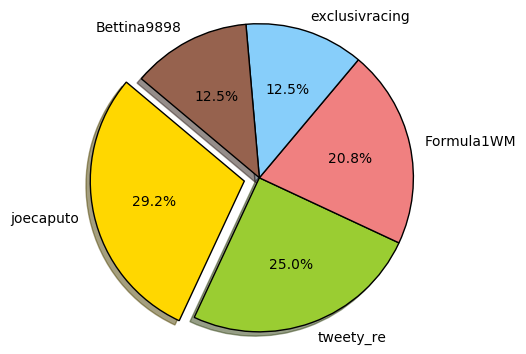

-------------------------------------------
Time: 2017-04-30 12:09:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:09:00
-------------------------------------------
2017-04-30 11:58:56
2017-04-30 11:58:56
2017-04-30 11:58:56
2017-04-30 11:58:57
2017-04-30 11:58:57
2017-04-30 11:58:57
2017-04-30 11:58:57
2017-04-30 11:58:57
2017-04-30 11:58:57
2017-04-30 11:58:57
...

-------------------------------------------
Time: 2017-04-30 12:09:00
-------------------------------------------
esslercart
MesQueUnClubXL
riyan_sengon
LewisArmy
Dukester_94
pinadero50
mena_CR
NascarLiveITA
exclusivracing
F1_Madness
...

-------------------------------------------
Time: 2017-04-30 12:09:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('exclusivracing', 4)
('rigorondon2017', 3)
...



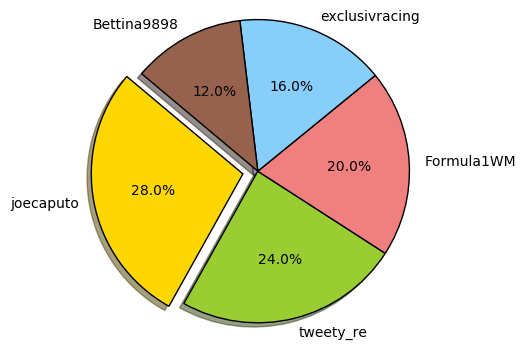

-------------------------------------------
Time: 2017-04-30 12:10:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:10:00
-------------------------------------------
2017-04-30 11:58:57
2017-04-30 11:58:57
2017-04-30 11:58:58
2017-04-30 11:58:58
2017-04-30 11:58:58
2017-04-30 11:58:58
2017-04-30 11:58:58
2017-04-30 11:58:58
2017-04-30 11:58:58
2017-04-30 11:58:59
...

-------------------------------------------
Time: 2017-04-30 12:10:00
-------------------------------------------
johanboes
Mickitaryan
Bettina9898
MEFLYINDUTCHMAN
Jup_Ohana
Anil_Ugur_
Motorz_jp
barrybazzabazF1
CronopioX
0mimamoruyo0
...

-------------------------------------------
Time: 2017-04-30 12:10:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('Bettina9898', 4)
...



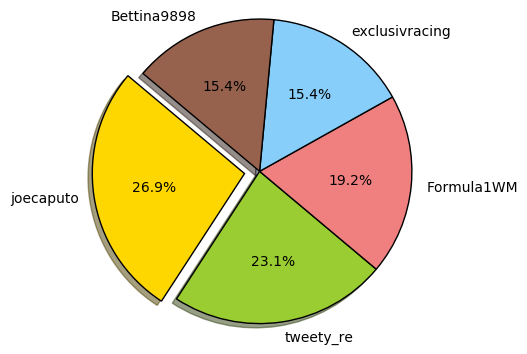

-------------------------------------------
Time: 2017-04-30 12:11:00
-------------------------------------------
Number of tweets this batch: 11

-------------------------------------------
Time: 2017-04-30 12:11:00
-------------------------------------------
2017-04-30 11:58:59
2017-04-30 11:58:59
2017-04-30 11:58:59
2017-04-30 11:58:59
2017-04-30 11:58:59
2017-04-30 11:58:59
2017-04-30 11:58:59
2017-04-30 11:59:00
2017-04-30 11:59:00
2017-04-30 12:10:50
...

-------------------------------------------
Time: 2017-04-30 12:11:00
-------------------------------------------
timkrueger_14
ElMoo2012
quakerstate_mx
DonPetrova
alan_alanp9373
HojasdeAlisio
harrythills
Ghost_7
FerrariRetweet
ma2_yuuki_0111
...

-------------------------------------------
Time: 2017-04-30 12:11:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('Bettina9898', 4)
...



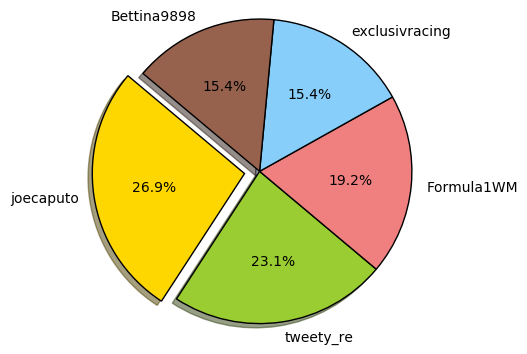

-------------------------------------------
Time: 2017-04-30 12:12:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:12:00
-------------------------------------------
2017-04-30 12:10:50
2017-04-30 12:10:50
2017-04-30 12:10:51
2017-04-30 12:10:51
2017-04-30 12:10:51
2017-04-30 12:10:51
2017-04-30 12:10:51
2017-04-30 12:10:51
2017-04-30 12:10:51
2017-04-30 12:10:51
...

-------------------------------------------
Time: 2017-04-30 12:12:00
-------------------------------------------
marytheluckyone
BaronVonClutch
ELEGBETE1
Adriano57441323
San_ler
Cindy__Idr
Eurosport_IT
MotorsportWeek
capturethecatch
mike_smith80
...

-------------------------------------------
Time: 2017-04-30 12:12:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('Bettina9898', 4)
...



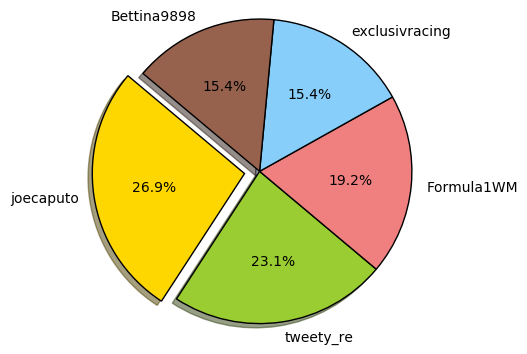

-------------------------------------------
Time: 2017-04-30 12:13:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:13:00
-------------------------------------------
2017-04-30 12:10:52
2017-04-30 12:10:52
2017-04-30 12:10:52
2017-04-30 12:10:52
2017-04-30 12:10:52
2017-04-30 12:10:52
2017-04-30 12:10:52
2017-04-30 12:10:52
2017-04-30 12:10:52
2017-04-30 12:10:52
...

-------------------------------------------
Time: 2017-04-30 12:13:00
-------------------------------------------
notmillena
BDarkrider
TeeJay_Ess
JoeSaunders46
a_rkw_ms
nuella93
jpappone
a99ress0r
CWBend
PlayTo_Die
...

-------------------------------------------
Time: 2017-04-30 12:13:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('Bettina9898', 4)
...



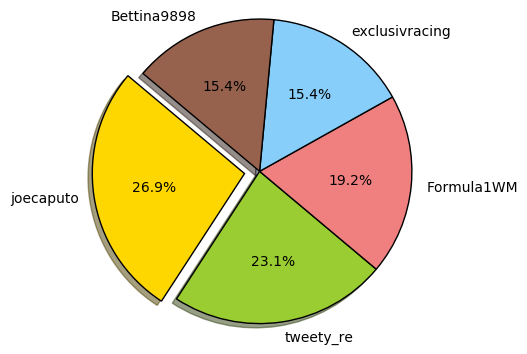

-------------------------------------------
Time: 2017-04-30 12:14:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:14:00
-------------------------------------------
2017-04-30 12:10:52
2017-04-30 12:10:52
2017-04-30 12:10:53
2017-04-30 12:10:53
2017-04-30 12:10:53
2017-04-30 12:10:53
2017-04-30 12:10:53
2017-04-30 12:10:54
2017-04-30 12:10:54
2017-04-30 12:10:54
...

-------------------------------------------
Time: 2017-04-30 12:14:00
-------------------------------------------
RRKCofK
hyonibee
BobbyDixon35
bonosjrvm
BiaRosenburg
bennnwjk
PublicautoChile
vhcracer
Proudracemum99
PRL_Stevie
...

-------------------------------------------
Time: 2017-04-30 12:14:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('Bettina9898', 4)
...



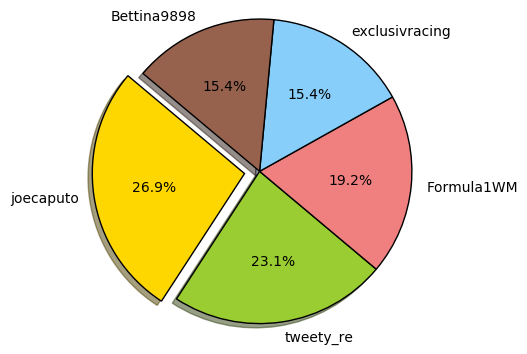

-------------------------------------------
Time: 2017-04-30 12:15:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:15:00
-------------------------------------------
2017-04-30 12:10:54
2017-04-30 12:10:54
2017-04-30 12:10:54
2017-04-30 12:10:54
2017-04-30 12:10:54
2017-04-30 12:10:54
2017-04-30 12:10:54
2017-04-30 12:10:54
2017-04-30 12:10:54
2017-04-30 12:10:54
...

-------------------------------------------
Time: 2017-04-30 12:15:00
-------------------------------------------
freelife1234567
edandawn
YaBoiMika
CansuCeyhann
svetformulelive
Sergio_Prez9
PoekieKim
evannecarlos17
JSalazar9
spectrecorrigan
...

-------------------------------------------
Time: 2017-04-30 12:15:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('Bettina9898', 4)
...



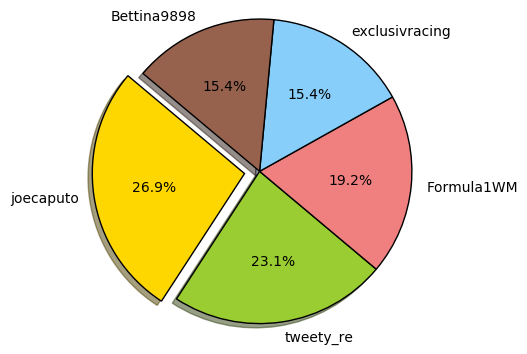

-------------------------------------------
Time: 2017-04-30 12:16:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:16:00
-------------------------------------------
2017-04-30 12:10:55
2017-04-30 12:10:55
2017-04-30 12:10:55
2017-04-30 12:10:55
2017-04-30 12:10:55
2017-04-30 12:10:55
2017-04-30 12:10:55
2017-04-30 12:10:55
2017-04-30 12:10:55
2017-04-30 12:10:55
...

-------------------------------------------
Time: 2017-04-30 12:16:00
-------------------------------------------
humaisf1
RezaPars
pedrorhormes
ravensock
AutobahnEU
luigimai
nohita
Eggydobrilho
Gabriel_RRC
Ratcliffe1981
...

-------------------------------------------
Time: 2017-04-30 12:16:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('exclusivracing', 4)
...



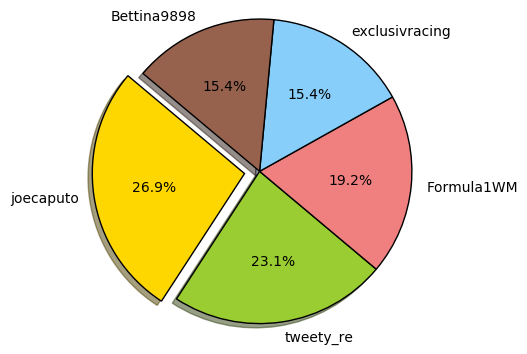

-------------------------------------------
Time: 2017-04-30 12:17:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:17:00
-------------------------------------------
2017-04-30 12:10:56
2017-04-30 12:10:56
2017-04-30 12:10:56
2017-04-30 12:10:56
2017-04-30 12:10:56
2017-04-30 12:10:56
2017-04-30 12:10:56
2017-04-30 12:10:56
2017-04-30 12:10:56
2017-04-30 12:10:56
...

-------------------------------------------
Time: 2017-04-30 12:17:00
-------------------------------------------
f1grip
Snakey_Uk
_4mich
adolfojbonilla
edandawn
Rosied34
jakenicholf1498
Pepealdanavaz
Robbie1896
bagelb0wse
...

-------------------------------------------
Time: 2017-04-30 12:17:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('exclusivracing', 4)
...



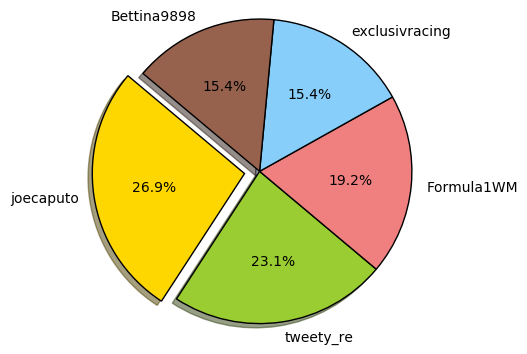

-------------------------------------------
Time: 2017-04-30 12:18:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:18:00
-------------------------------------------
2017-04-30 12:10:57
2017-04-30 12:10:57
2017-04-30 12:10:57
2017-04-30 12:10:57
2017-04-30 12:10:57
2017-04-30 12:10:57
2017-04-30 12:10:57
2017-04-30 12:10:57
2017-04-30 12:10:57
2017-04-30 12:10:57
...

-------------------------------------------
Time: 2017-04-30 12:18:00
-------------------------------------------
MarcosTrujill0
Sabzeero
StuartEdwards
SASedor2994
SkySportF1HD
HankPym_
SKRWildfire
miladinniz
GabyManzoJ
AJL_F1
...

-------------------------------------------
Time: 2017-04-30 12:18:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('exclusivracing', 4)
...



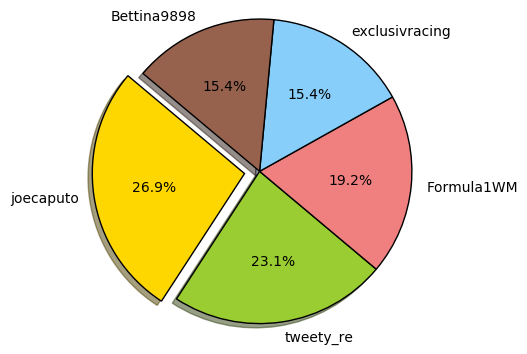

-------------------------------------------
Time: 2017-04-30 12:19:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:19:00
-------------------------------------------
2017-04-30 12:10:58
2017-04-30 12:10:58
2017-04-30 12:10:58
2017-04-30 12:10:58
2017-04-30 12:10:58
2017-04-30 12:10:58
2017-04-30 12:10:58
2017-04-30 12:10:58
2017-04-30 12:10:58
2017-04-30 12:10:58
...

-------------------------------------------
Time: 2017-04-30 12:19:00
-------------------------------------------
LastWordOnF1
mrc037
pal1892
kishiro26
Mulsanne96
MarcioDutra01
ActiveKritizen
contafisca
Tiana0109
a4dw564qwd56d3
...

-------------------------------------------
Time: 2017-04-30 12:19:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('exclusivracing', 4)
...



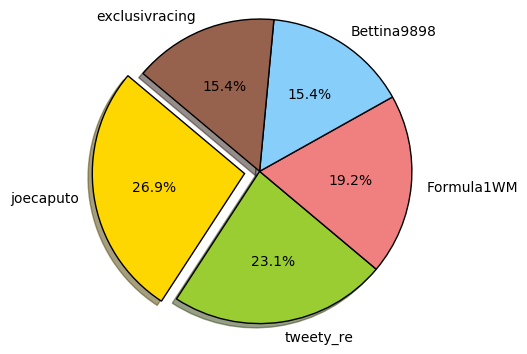

-------------------------------------------
Time: 2017-04-30 12:20:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:20:00
-------------------------------------------
2017-04-30 12:10:58
2017-04-30 12:10:58
2017-04-30 12:10:58
2017-04-30 12:10:58
2017-04-30 12:10:58
2017-04-30 12:10:59
2017-04-30 12:10:59
2017-04-30 12:10:59
2017-04-30 12:10:59
2017-04-30 12:10:59
...

-------------------------------------------
Time: 2017-04-30 12:20:00
-------------------------------------------
JWiniciusG
pvalstar
BoxOfNeutrals
AngelicaEstrad
sedadilek
LegrandG1
HitendraRTPatel
Tabascow972
Cfc_Craig
AlexBright56
...

-------------------------------------------
Time: 2017-04-30 12:20:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('exclusivracing', 4)
...



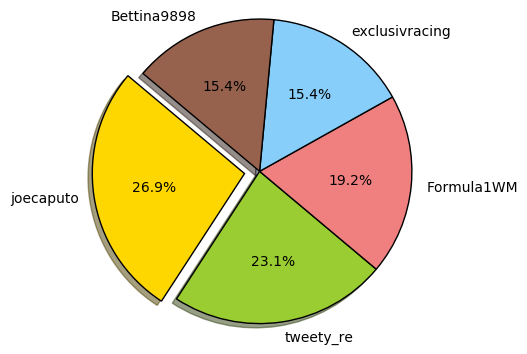

-------------------------------------------
Time: 2017-04-30 12:21:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:21:00
-------------------------------------------
2017-04-30 12:10:59
2017-04-30 12:10:59
2017-04-30 12:10:59
2017-04-30 12:10:59
2017-04-30 12:10:59
2017-04-30 12:10:59
2017-04-30 12:10:59
2017-04-30 12:11:00
2017-04-30 12:11:00
2017-04-30 12:11:00
...

-------------------------------------------
Time: 2017-04-30 12:21:00
-------------------------------------------
philsantos13
LcwilaCampos
Martin_NMX
toooldtobehook
kamromero
katerimarietta
AbbinanteV
FranciscoAure
BrownSquirrel
the_motonomad
...

-------------------------------------------
Time: 2017-04-30 12:21:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('exclusivracing', 4)
...



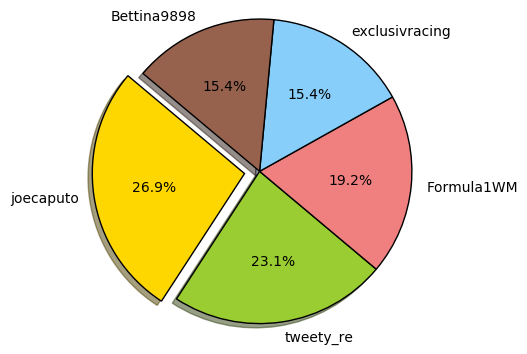

-------------------------------------------
Time: 2017-04-30 12:22:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:22:00
-------------------------------------------
2017-04-30 12:11:00
2017-04-30 12:11:00
2017-04-30 12:11:00
2017-04-30 12:11:00
2017-04-30 12:11:00
2017-04-30 12:11:00
2017-04-30 12:11:00
2017-04-30 12:11:01
2017-04-30 12:11:01
2017-04-30 12:11:01
...

-------------------------------------------
Time: 2017-04-30 12:22:00
-------------------------------------------
wsmithjake
MrZlatkovic
kngbrkykpck
Msport_Snippets
anniesnomsblog
Buxx_B
formularum
Migui95
leonovoh
fifimana2983
...

-------------------------------------------
Time: 2017-04-30 12:22:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('exclusivracing', 4)
...



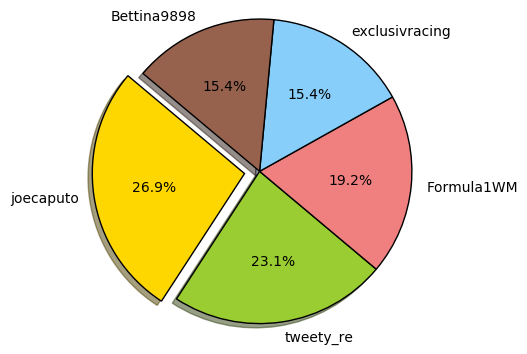

-------------------------------------------
Time: 2017-04-30 12:23:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:23:00
-------------------------------------------
2017-04-30 12:11:01
2017-04-30 12:11:01
2017-04-30 12:11:01
2017-04-30 12:11:01
2017-04-30 12:11:01
2017-04-30 12:11:01
2017-04-30 12:11:01
2017-04-30 12:11:01
2017-04-30 12:11:01
2017-04-30 12:11:01
...

-------------------------------------------
Time: 2017-04-30 12:23:00
-------------------------------------------
HuumanAfterAll
gathara
joslumugi
ss_may5
RobGT81
Dutriac
GipsyMonkeyMeg
msgaiafalanga
hprs1969
motorsport_geek
...

-------------------------------------------
Time: 2017-04-30 12:23:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('exclusivracing', 4)
...



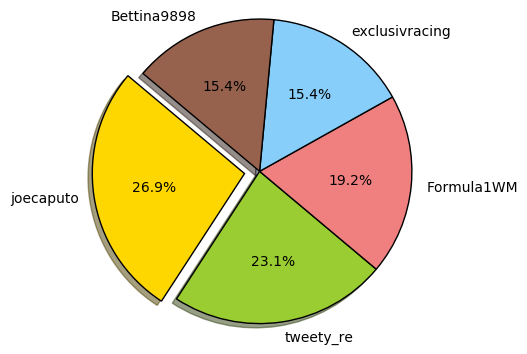

-------------------------------------------
Time: 2017-04-30 12:24:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:24:00
-------------------------------------------
2017-04-30 12:11:02
2017-04-30 12:11:02
2017-04-30 12:11:02
2017-04-30 12:11:02
2017-04-30 12:11:02
2017-04-30 12:11:02
2017-04-30 12:11:02
2017-04-30 12:11:02
2017-04-30 12:11:02
2017-04-30 12:11:02
...

-------------------------------------------
Time: 2017-04-30 12:24:00
-------------------------------------------
Nimroadt
HankPym_
manuel_rodero99
TheBigBadWolfe_
AdamBurrellzz
ritesh0_0
_SaraShafek
fantasticoF1
f1lineup
f1akb
...

-------------------------------------------
Time: 2017-04-30 12:24:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('exclusivracing', 4)
...



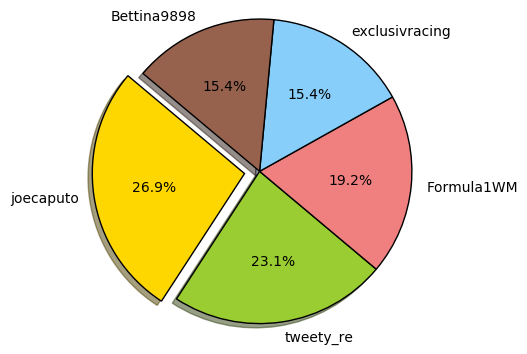

-------------------------------------------
Time: 2017-04-30 12:25:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:25:00
-------------------------------------------
2017-04-30 12:11:02
2017-04-30 12:11:03
2017-04-30 12:11:02
2017-04-30 12:11:03
2017-04-30 12:11:03
2017-04-30 12:11:03
2017-04-30 12:11:03
2017-04-30 12:11:03
2017-04-30 12:11:03
2017-04-30 12:11:03
...

-------------------------------------------
Time: 2017-04-30 12:25:00
-------------------------------------------
mcrisever
forf1ssake
LevEakins
rubenike_94
edandawn
mahk_marsha
oliviagrant68
kunalashah
mmf1_
AyelenPorco
...

-------------------------------------------
Time: 2017-04-30 12:25:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('exclusivracing', 4)
...



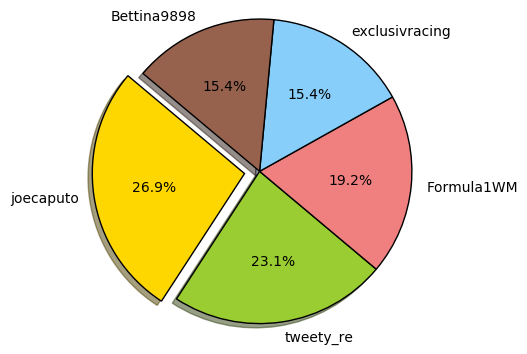

-------------------------------------------
Time: 2017-04-30 12:26:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:26:00
-------------------------------------------
2017-04-30 12:11:03
2017-04-30 12:11:03
2017-04-30 12:11:03
2017-04-30 12:11:03
2017-04-30 12:11:03
2017-04-30 12:11:03
2017-04-30 12:11:03
2017-04-30 12:11:04
2017-04-30 12:11:04
2017-04-30 12:11:04
...

-------------------------------------------
Time: 2017-04-30 12:26:00
-------------------------------------------
cristianars
MarinaGironS
stevecurtis_85
wtf1official
kelaodalis
Zaff87
4lifestan
Anaelle_MD
frillipe
Alk_Zetta
...

-------------------------------------------
Time: 2017-04-30 12:26:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('exclusivracing', 4)
...



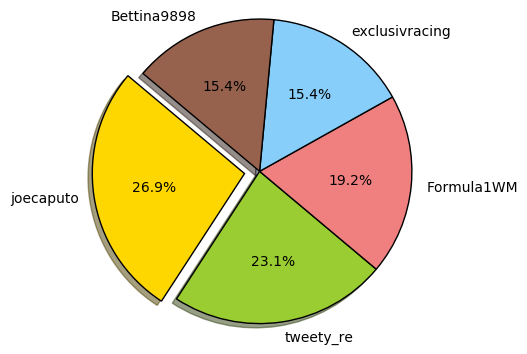

-------------------------------------------
Time: 2017-04-30 12:27:00
-------------------------------------------
Number of tweets this batch: 11

-------------------------------------------
Time: 2017-04-30 12:27:00
-------------------------------------------
2017-04-30 12:11:04
2017-04-30 12:11:04
2017-04-30 12:11:04
2017-04-30 12:11:04
2017-04-30 12:11:04
2017-04-30 12:11:04
2017-04-30 12:11:04
2017-04-30 12:11:04
2017-04-30 12:11:04
2017-04-30 12:11:04
...

-------------------------------------------
Time: 2017-04-30 12:27:00
-------------------------------------------
Ootkarsh
bieberftasensio
KevinJay89
frank_wrc
seanylpa
objectivelyjoe
Motorpad
carlosainzinfo
theMiniNino
Secteur_F1
...

-------------------------------------------
Time: 2017-04-30 12:27:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('exclusivracing', 4)
...



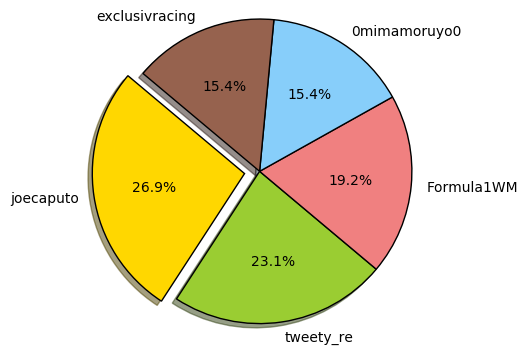

-------------------------------------------
Time: 2017-04-30 12:28:00
-------------------------------------------
Number of tweets this batch: 6

-------------------------------------------
Time: 2017-04-30 12:28:00
-------------------------------------------
2017-04-30 12:27:29
2017-04-30 12:27:29
2017-04-30 12:27:30
2017-04-30 12:27:30
2017-04-30 12:27:30
2017-04-30 12:27:30

-------------------------------------------
Time: 2017-04-30 12:28:00
-------------------------------------------
Roses_Spades
SPEED
skybluemandylou
Baartbek
LotusEliseGT1
gabrielfbn

-------------------------------------------
Time: 2017-04-30 12:28:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('exclusivracing', 4)
...



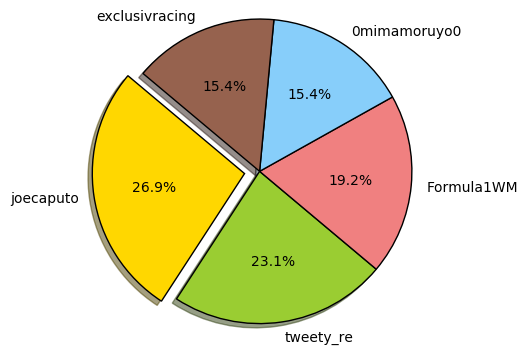

-------------------------------------------
Time: 2017-04-30 12:29:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:29:00
-------------------------------------------
2017-04-30 12:27:30
2017-04-30 12:27:30
2017-04-30 12:27:31
2017-04-30 12:27:31
2017-04-30 12:27:31
2017-04-30 12:27:31
2017-04-30 12:27:31
2017-04-30 12:27:31
2017-04-30 12:27:31
2017-04-30 12:27:31
...

-------------------------------------------
Time: 2017-04-30 12:29:00
-------------------------------------------
kamuinamazu
jm_cls
quaranta_vito
JassFm19
SenDonPius
Sergio_Prez9
dmiller742
titter_me_not
STBoomish
Shernmar
...

-------------------------------------------
Time: 2017-04-30 12:29:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('exclusivracing', 4)
...



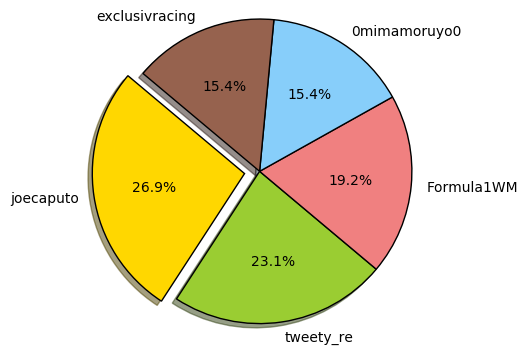

-------------------------------------------
Time: 2017-04-30 12:30:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:30:00
-------------------------------------------
2017-04-30 12:27:32
2017-04-30 12:27:32
2017-04-30 12:27:32
2017-04-30 12:27:32
2017-04-30 12:27:32
2017-04-30 12:27:32
2017-04-30 12:27:33
2017-04-30 12:27:33
2017-04-30 12:27:33
2017-04-30 12:27:33
...

-------------------------------------------
Time: 2017-04-30 12:30:00
-------------------------------------------
mverstappenfans
simply_formula
Natan_Silva77
ThisIsMyBubble
KikeCardoso
5acesports
GrandPrixDiary
BaronVonClutch
chompy94
_ManuelAcuna
...

-------------------------------------------
Time: 2017-04-30 12:30:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('exclusivracing', 4)
...



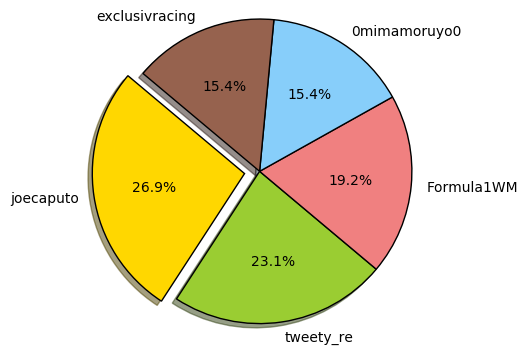

-------------------------------------------
Time: 2017-04-30 12:31:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:31:00
-------------------------------------------
2017-04-30 12:27:34
2017-04-30 12:27:34
2017-04-30 12:27:34
2017-04-30 12:27:35
2017-04-30 12:27:35
2017-04-30 12:27:35
2017-04-30 12:27:35
2017-04-30 12:27:35
2017-04-30 12:27:35
2017-04-30 12:27:35
...

-------------------------------------------
Time: 2017-04-30 12:31:00
-------------------------------------------
vrncf
IamRJ95
FerrariKiyoshi
DehFlowers
Botado2
senzabigshot
YEYOVOX
LovelandMJ
ElvisObara
TraceyManus
...

-------------------------------------------
Time: 2017-04-30 12:31:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('exclusivracing', 4)
...



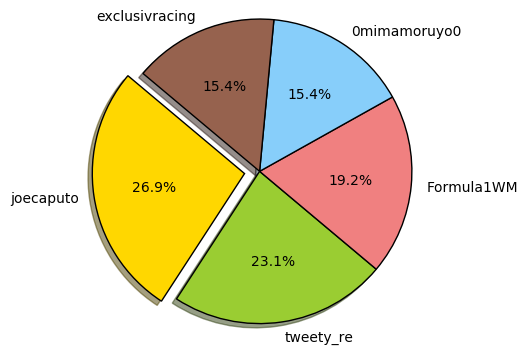

-------------------------------------------
Time: 2017-04-30 12:32:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:32:00
-------------------------------------------
2017-04-30 12:27:35
2017-04-30 12:27:35
2017-04-30 12:27:36
2017-04-30 12:27:36
2017-04-30 12:27:36
2017-04-30 12:27:36
2017-04-30 12:27:36
2017-04-30 12:27:36
2017-04-30 12:27:37
2017-04-30 12:27:36
...

-------------------------------------------
Time: 2017-04-30 12:32:00
-------------------------------------------
HJMyllyla
idashKB
JuuliaHeidi
BenzerBett
JesusColprim
lisouis
SoniaMorellato1
loadsoffandoms
ChrisPips
Luminno_Ltd
...

-------------------------------------------
Time: 2017-04-30 12:32:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('exclusivracing', 4)
...



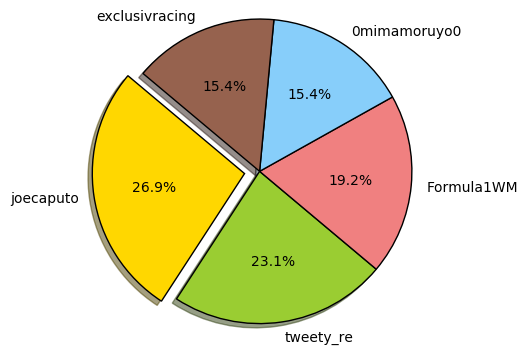

-------------------------------------------
Time: 2017-04-30 12:33:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:33:00
-------------------------------------------
2017-04-30 12:27:37
2017-04-30 12:27:37
2017-04-30 12:27:37
2017-04-30 12:27:37
2017-04-30 12:27:38
2017-04-30 12:27:38
2017-04-30 12:27:38
2017-04-30 12:27:38
2017-04-30 12:27:38
2017-04-30 12:27:38
...

-------------------------------------------
Time: 2017-04-30 12:33:00
-------------------------------------------
miguelon986
jpavlovic801
Humphreymutai
CarlosNeon3
LN997
ActuF1FR
johnny_johnsen
VPNSports
hopd10
Guynemer84
...

-------------------------------------------
Time: 2017-04-30 12:33:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('LastWordOnF1', 4)
...



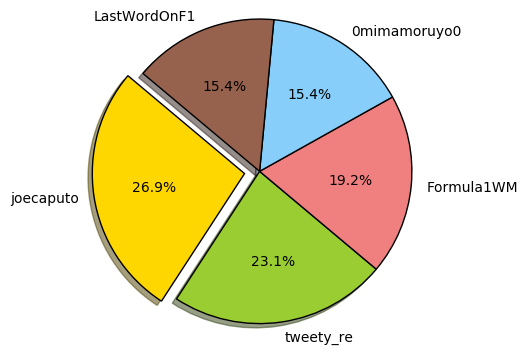

-------------------------------------------
Time: 2017-04-30 12:34:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:34:00
-------------------------------------------
2017-04-30 12:27:40
2017-04-30 12:27:39
2017-04-30 12:27:40
2017-04-30 12:27:40
2017-04-30 12:27:40
2017-04-30 12:27:40
2017-04-30 12:27:41
2017-04-30 12:27:41
2017-04-30 12:27:41
2017-04-30 12:27:41
...

-------------------------------------------
Time: 2017-04-30 12:34:00
-------------------------------------------
AndreDonaldson_
F1Brasi1
charlieagu
LunarStill
NAbbott80
lucaselias20
r_lainy
Darth_Fenix
andres_pirazan
F1Loopy
...

-------------------------------------------
Time: 2017-04-30 12:34:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('LastWordOnF1', 4)
...



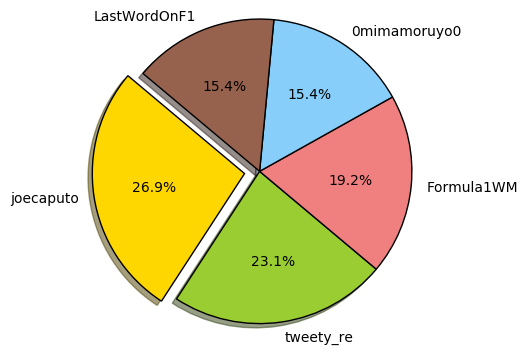

-------------------------------------------
Time: 2017-04-30 12:35:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:35:00
-------------------------------------------
2017-04-30 12:27:42
2017-04-30 12:27:42
2017-04-30 12:27:42
2017-04-30 12:27:42
2017-04-30 12:27:43
2017-04-30 12:27:43
2017-04-30 12:27:43
2017-04-30 12:27:43
2017-04-30 12:27:43
2017-04-30 12:27:44
...

-------------------------------------------
Time: 2017-04-30 12:35:00
-------------------------------------------
MrsLAKnowles
estoenlinea
Pabloidc
kristinekirby
MercedesFansDe
kesselkind70188
dorisramos01
CarbieWarbie
chloeclojo
F1_Madness
...

-------------------------------------------
Time: 2017-04-30 12:35:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('LastWordOnF1', 4)
...



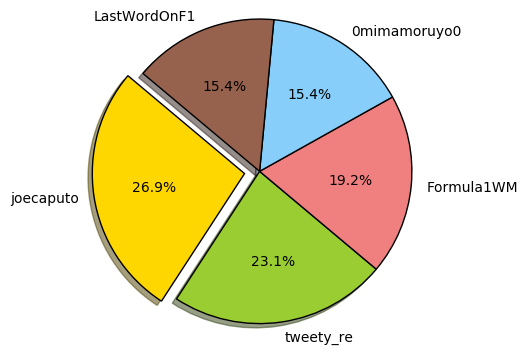

-------------------------------------------
Time: 2017-04-30 12:36:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:36:00
-------------------------------------------
2017-04-30 12:27:44
2017-04-30 12:27:44
2017-04-30 12:27:44
2017-04-30 12:27:44
2017-04-30 12:27:44
2017-04-30 12:27:44
2017-04-30 12:27:44
2017-04-30 12:27:45
2017-04-30 12:27:45
2017-04-30 12:27:45
...

-------------------------------------------
Time: 2017-04-30 12:36:00
-------------------------------------------
Baartbek
carcarla81
GejoAleksandar
Abrahambr75
bbcf1
FeralMotorsport
Formula1_MotoGP
FeralMotorsport
maria_ruiz94
K_Ban
...

-------------------------------------------
Time: 2017-04-30 12:36:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('LastWordOnF1', 4)
...



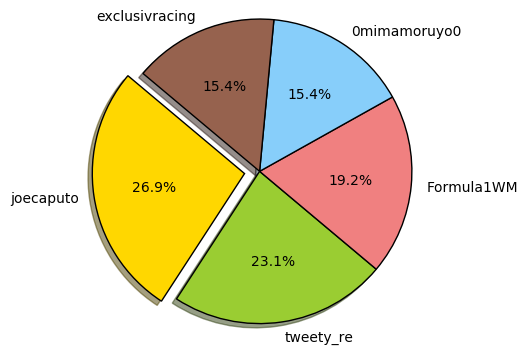

-------------------------------------------
Time: 2017-04-30 12:37:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:37:00
-------------------------------------------
2017-04-30 12:27:45
2017-04-30 12:27:45
2017-04-30 12:27:46
2017-04-30 12:27:46
2017-04-30 12:27:46
2017-04-30 12:27:46
2017-04-30 12:27:46
2017-04-30 12:27:46
2017-04-30 12:27:46
2017-04-30 12:27:47
...

-------------------------------------------
Time: 2017-04-30 12:37:00
-------------------------------------------
batchof98
F1World504
clau77b
maririayayu
JoshMyah
Gini_Koch
g3of1
P2_Brewster
MrDangerDaysF1
TimurMusin
...

-------------------------------------------
Time: 2017-04-30 12:37:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('LastWordOnF1', 4)
...



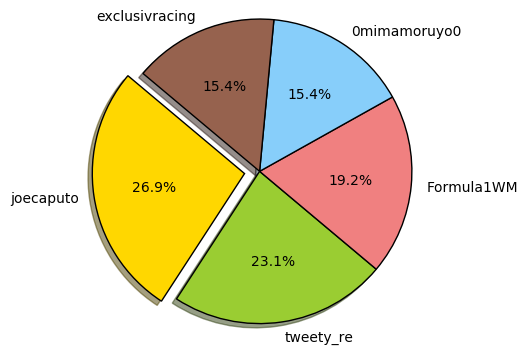

-------------------------------------------
Time: 2017-04-30 12:38:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:38:00
-------------------------------------------
2017-04-30 12:27:47
2017-04-30 12:27:47
2017-04-30 12:27:47
2017-04-30 12:27:47
2017-04-30 12:27:48
2017-04-30 12:27:48
2017-04-30 12:27:48
2017-04-30 12:27:48
2017-04-30 12:27:48
2017-04-30 12:27:48
...

-------------------------------------------
Time: 2017-04-30 12:38:00
-------------------------------------------
JamesWagnerTW
BravoFernandoF1
donald_dmubva
MMcInerney89
carola_floriano
davve2010
RBBRulesBenitez
dburgersdijk
LewisFranck
IndianGrit
...

-------------------------------------------
Time: 2017-04-30 12:38:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('LastWordOnF1', 4)
...



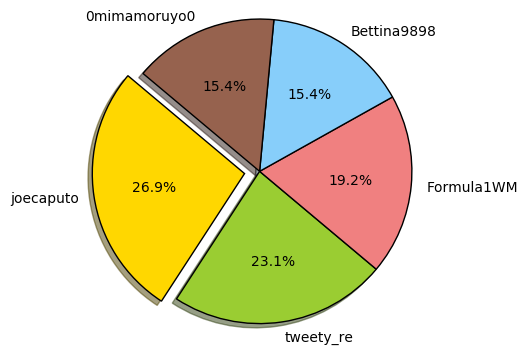

-------------------------------------------
Time: 2017-04-30 12:39:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:39:00
-------------------------------------------
2017-04-30 12:27:49
2017-04-30 12:27:49
2017-04-30 12:27:49
2017-04-30 12:27:49
2017-04-30 12:27:49
2017-04-30 12:27:50
2017-04-30 12:27:50
2017-04-30 12:27:50
2017-04-30 12:27:51
2017-04-30 12:27:51
...

-------------------------------------------
Time: 2017-04-30 12:39:00
-------------------------------------------
kl_motorsport
RulesBenitez
wcooper8
FastETC
elena_elve
desperatearch_
TelegraphSport
LoretoSerrano8
rjarufe
sameeroptics
...

-------------------------------------------
Time: 2017-04-30 12:39:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('LastWordOnF1', 4)
...



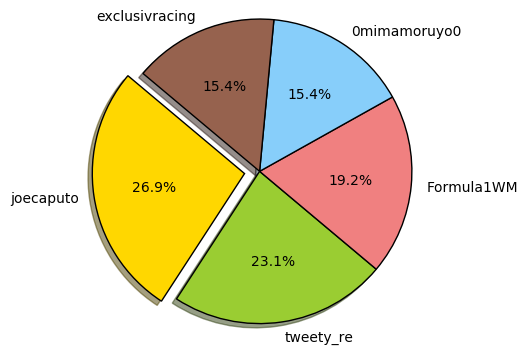

-------------------------------------------
Time: 2017-04-30 12:40:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:40:00
-------------------------------------------
2017-04-30 12:27:51
2017-04-30 12:27:52
2017-04-30 12:27:52
2017-04-30 12:27:52
2017-04-30 12:27:52
2017-04-30 12:27:52
2017-04-30 12:27:52
2017-04-30 12:27:52
2017-04-30 12:27:52
2017-04-30 12:27:52
...

-------------------------------------------
Time: 2017-04-30 12:40:00
-------------------------------------------
LiteralF1
onasixpence
IndianGrit
squirrel15_
charlie_whiting
gpilbro
AlutaMaqoko
albertrotskigm2
Motor_TE
a_rkw_ms
...

-------------------------------------------
Time: 2017-04-30 12:40:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('LastWordOnF1', 4)
...



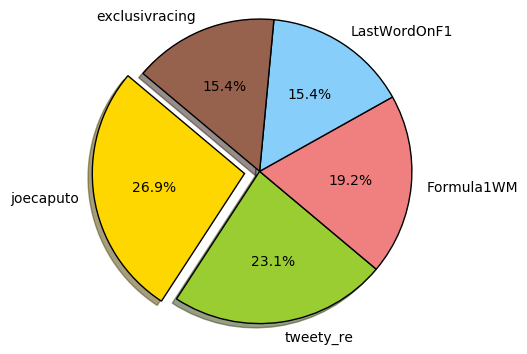

-------------------------------------------
Time: 2017-04-30 12:41:00
-------------------------------------------
Number of tweets this batch: 7

-------------------------------------------
Time: 2017-04-30 12:41:00
-------------------------------------------
2017-04-30 12:27:52
2017-04-30 12:27:52
2017-04-30 12:27:52
2017-04-30 12:27:53
2017-04-30 12:27:53
2017-04-30 12:27:53
2017-04-30 12:40:54

-------------------------------------------
Time: 2017-04-30 12:41:00
-------------------------------------------
simply_formula
DavidAle25
weikai615
F1grid
UltimateWebFan
filhopaulo2012
skopal

-------------------------------------------
Time: 2017-04-30 12:41:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('LastWordOnF1', 4)
...



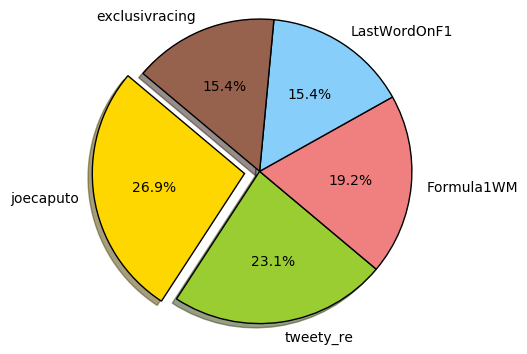

-------------------------------------------
Time: 2017-04-30 12:42:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:42:00
-------------------------------------------
2017-04-30 12:40:54
2017-04-30 12:40:54
2017-04-30 12:40:55
2017-04-30 12:40:55
2017-04-30 12:40:55
2017-04-30 12:40:55
2017-04-30 12:40:55
2017-04-30 12:40:55
2017-04-30 12:40:55
2017-04-30 12:40:56
...

-------------------------------------------
Time: 2017-04-30 12:42:00
-------------------------------------------
ruchasharma
HAMazingLew
andermento
Lebarois
vLionMan
Monalisazelf
robsijberden
RussellsTranspo
Katlom80R
AKkfa
...

-------------------------------------------
Time: 2017-04-30 12:42:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('LastWordOnF1', 4)
...



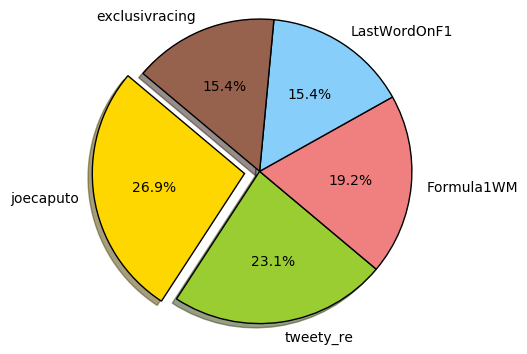

-------------------------------------------
Time: 2017-04-30 12:43:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:43:00
-------------------------------------------
2017-04-30 12:40:56
2017-04-30 12:40:56
2017-04-30 12:40:56
2017-04-30 12:40:56
2017-04-30 12:40:56
2017-04-30 12:40:56
2017-04-30 12:40:56
2017-04-30 12:40:57
2017-04-30 12:40:57
2017-04-30 12:40:57
...

-------------------------------------------
Time: 2017-04-30 12:43:00
-------------------------------------------
atodaf1
AutobahnEU
parejasimo10
trevor_players
Atilem6
Rguzmanv85
ProudOfLH
banheirinha
trulli_train
ClaudioErdellan
...

-------------------------------------------
Time: 2017-04-30 12:43:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('LastWordOnF1', 4)
...



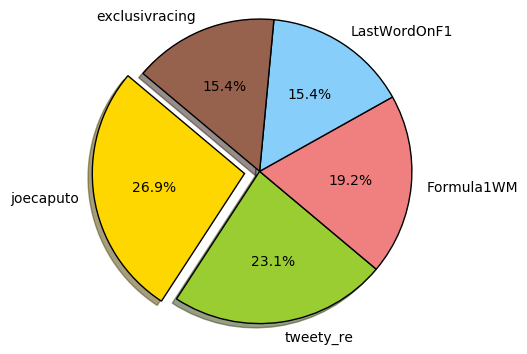

-------------------------------------------
Time: 2017-04-30 12:44:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:44:00
-------------------------------------------
2017-04-30 12:40:57
2017-04-30 12:40:57
2017-04-30 12:40:57
2017-04-30 12:40:57
2017-04-30 12:40:57
2017-04-30 12:40:58
2017-04-30 12:40:58
2017-04-30 12:40:58
2017-04-30 12:40:58
2017-04-30 12:40:58
...

-------------------------------------------
Time: 2017-04-30 12:44:00
-------------------------------------------
zoonmattau
explenture
Pentanix_
F1_Madness
TebelloJone04
erwinzaguilar
DitaDobranja
Becks_F1
Porte_45
Monti10000
...

-------------------------------------------
Time: 2017-04-30 12:44:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('LastWordOnF1', 4)
...



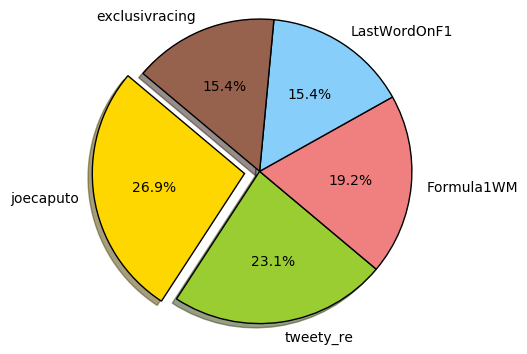

-------------------------------------------
Time: 2017-04-30 12:45:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:45:00
-------------------------------------------
2017-04-30 12:40:58
2017-04-30 12:40:59
2017-04-30 12:40:59
2017-04-30 12:40:59
2017-04-30 12:40:59
2017-04-30 12:40:59
2017-04-30 12:40:59
2017-04-30 12:40:59
2017-04-30 12:41:00
2017-04-30 12:41:01
...

-------------------------------------------
Time: 2017-04-30 12:45:00
-------------------------------------------
vergili_kubilay
valencianistus
rachelbbridge
albertrotskigm2
christianbelko
y2jluca
kehindebadejo
Qiqa
NOT_DiGITAL_
F1racing
...

-------------------------------------------
Time: 2017-04-30 12:45:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('LastWordOnF1', 4)
...



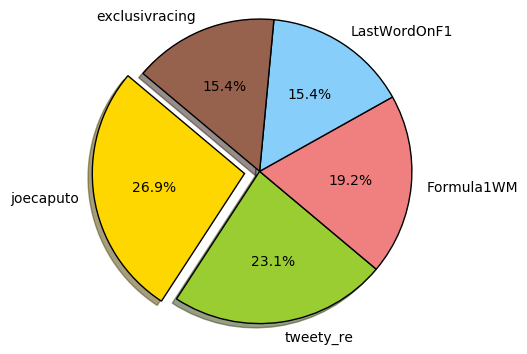

-------------------------------------------
Time: 2017-04-30 12:46:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:46:00
-------------------------------------------
2017-04-30 12:41:01
2017-04-30 12:41:01
2017-04-30 12:41:01
2017-04-30 12:41:01
2017-04-30 12:41:02
2017-04-30 12:41:02
2017-04-30 12:41:02
2017-04-30 12:41:02
2017-04-30 12:41:02
2017-04-30 12:41:02
...

-------------------------------------------
Time: 2017-04-30 12:46:00
-------------------------------------------
biografiasf1
Becks_F1
lebsight
mic_cro18
BiaRosenburg
nefcelis
Bender_SRT
RRodrigo206
ErdiFuzuLi
dustin_n_va
...

-------------------------------------------
Time: 2017-04-30 12:46:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('LastWordOnF1', 4)
...



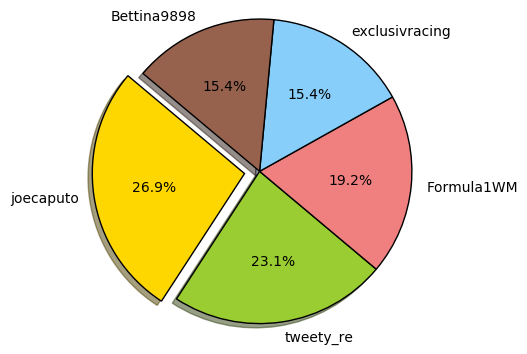

-------------------------------------------
Time: 2017-04-30 12:47:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:47:00
-------------------------------------------
2017-04-30 12:41:03
2017-04-30 12:41:03
2017-04-30 12:41:03
2017-04-30 12:41:03
2017-04-30 12:41:03
2017-04-30 12:41:03
2017-04-30 12:41:03
2017-04-30 12:41:04
2017-04-30 12:41:04
2017-04-30 12:41:03
...

-------------------------------------------
Time: 2017-04-30 12:47:00
-------------------------------------------
Adriano57441323
katyoun_hana
TonnieSeawolf
vanesaF1
fsm67
jakenicholf1498
MCoRacingTeam
explenture
misshka
ESPNF1
...

-------------------------------------------
Time: 2017-04-30 12:47:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('LastWordOnF1', 4)
...



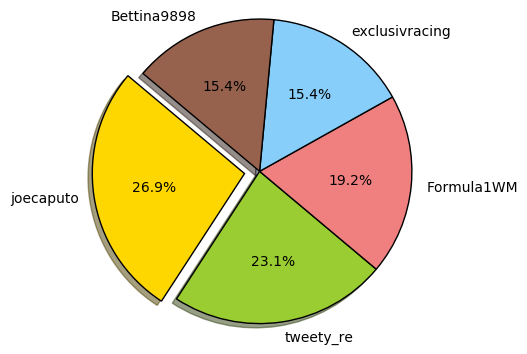

-------------------------------------------
Time: 2017-04-30 12:48:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:48:00
-------------------------------------------
2017-04-30 12:41:04
2017-04-30 12:41:04
2017-04-30 12:41:04
2017-04-30 12:41:05
2017-04-30 12:41:05
2017-04-30 12:41:05
2017-04-30 12:41:05
2017-04-30 12:41:05
2017-04-30 12:41:03
2017-04-30 12:41:06
...

-------------------------------------------
Time: 2017-04-30 12:48:00
-------------------------------------------
AttachMax
auto_dtribe
eggry
Adriano57441323
formulaspy
Mr_Marza
saffarmohamed
TenienteRiff
fsm67
Soy_F1
...

-------------------------------------------
Time: 2017-04-30 12:48:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('LastWordOnF1', 4)
...



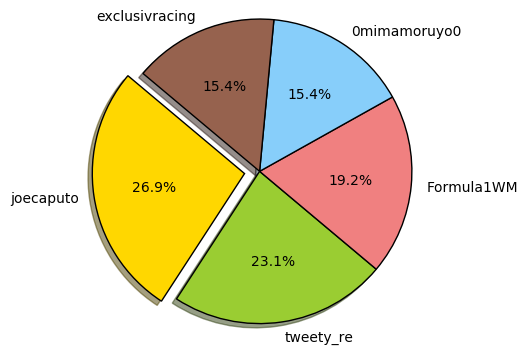

-------------------------------------------
Time: 2017-04-30 12:49:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:49:00
-------------------------------------------
2017-04-30 12:41:06
2017-04-30 12:41:06
2017-04-30 12:41:03
2017-04-30 12:41:07
2017-04-30 12:41:07
2017-04-30 12:41:07
2017-04-30 12:41:07
2017-04-30 12:41:07
2017-04-30 12:41:07
2017-04-30 12:41:08
...

-------------------------------------------
Time: 2017-04-30 12:49:00
-------------------------------------------
koengodderis
PanosSeitanidis
MCoRacingTeam
EnzoFerrariLfc
TrendsArab
pitlane_girl
bryan_ikhalachi
1F_AnnaRe
managerchampion
moshamora
...

-------------------------------------------
Time: 2017-04-30 12:49:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('LastWordOnF1', 4)
...



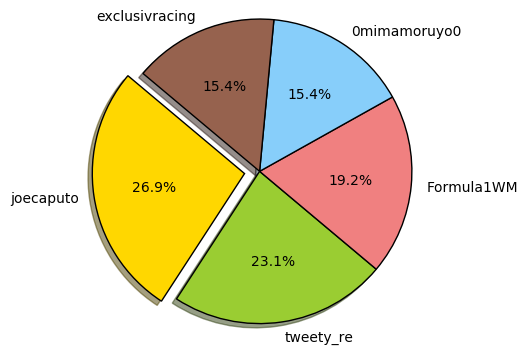

-------------------------------------------
Time: 2017-04-30 12:50:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:50:00
-------------------------------------------
2017-04-30 12:41:09
2017-04-30 12:41:09
2017-04-30 12:41:09
2017-04-30 12:41:09
2017-04-30 12:41:09
2017-04-30 12:41:09
2017-04-30 12:41:09
2017-04-30 12:41:10
2017-04-30 12:41:10
2017-04-30 12:41:10
...

-------------------------------------------
Time: 2017-04-30 12:50:00
-------------------------------------------
quick_synchro
24usamaru
ariemeijer
AutobahnEU
gerkleinekoort
andrewsoares89
calvinbooklover
chansida14
sanmibor
lilbatureIII
...

-------------------------------------------
Time: 2017-04-30 12:50:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('0mimamoruyo0', 4)
('LastWordOnF1', 4)
...



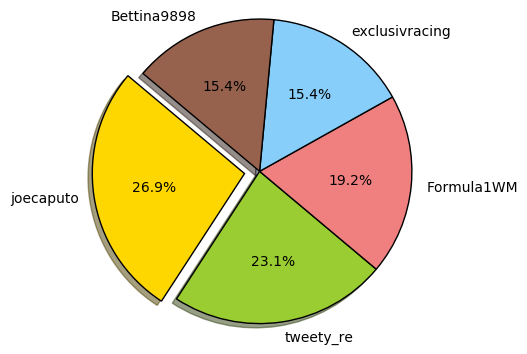

-------------------------------------------
Time: 2017-04-30 12:51:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:51:00
-------------------------------------------
2017-04-30 12:41:10
2017-04-30 12:41:11
2017-04-30 12:41:11
2017-04-30 12:41:11
2017-04-30 12:41:11
2017-04-30 12:41:11
2017-04-30 12:41:11
2017-04-30 12:41:11
2017-04-30 12:41:11
2017-04-30 12:41:12
...

-------------------------------------------
Time: 2017-04-30 12:51:00
-------------------------------------------
borntolovef1
auto_dtribe
jainishkothary
MateoROchoa
Peter_33_RB_Fan
laurinahwhy
Mastaf1
MiyuriScarlet
thewahaman
Mzco_Life
...

-------------------------------------------
Time: 2017-04-30 12:51:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('LastWordOnF1', 4)
('exclusivracing', 4)
...



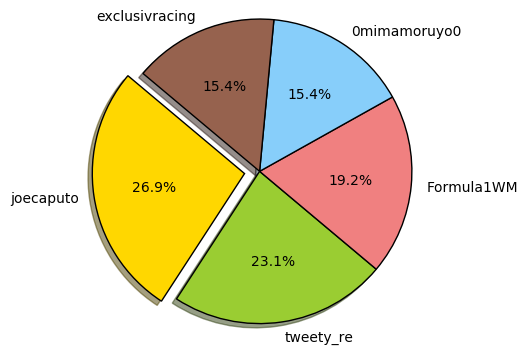

-------------------------------------------
Time: 2017-04-30 12:52:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:52:00
-------------------------------------------
2017-04-30 12:41:12
2017-04-30 12:41:12
2017-04-30 12:41:12
2017-04-30 12:41:12
2017-04-30 12:41:12
2017-04-30 12:41:13
2017-04-30 12:41:13
2017-04-30 12:41:13
2017-04-30 12:41:13
2017-04-30 12:41:13
...

-------------------------------------------
Time: 2017-04-30 12:52:00
-------------------------------------------
MxMGarces
PimSterenberg
GridGirl_
remybergsma
StegemaFia
dustin_n_va
L0Barry
whitediamond_S
auto_dtribe
itsmecaia
...

-------------------------------------------
Time: 2017-04-30 12:52:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('LastWordOnF1', 4)
('exclusivracing', 4)
...



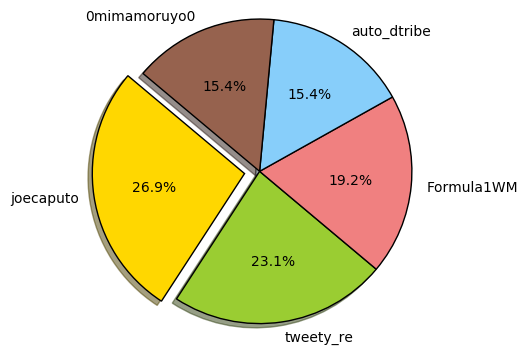

-------------------------------------------
Time: 2017-04-30 12:53:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:53:00
-------------------------------------------
2017-04-30 12:41:14
2017-04-30 12:41:14
2017-04-30 12:41:14
2017-04-30 12:41:15
2017-04-30 12:41:15
2017-04-30 12:41:15
2017-04-30 12:41:15
2017-04-30 12:41:15
2017-04-30 12:41:15
2017-04-30 12:41:15
...

-------------------------------------------
Time: 2017-04-30 12:53:00
-------------------------------------------
Craig_O_F1
F1Tricky
artthurv
Serena073
fugotaro
BetFastBTC
GuiBroietti22
alstewitn
Formula1_MotoGP
Formula1Girll
...

-------------------------------------------
Time: 2017-04-30 12:53:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('LastWordOnF1', 4)
('exclusivracing', 4)
...



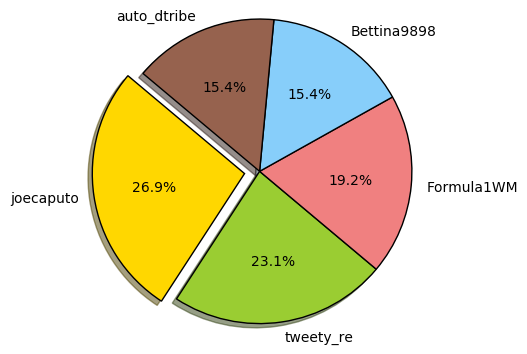

-------------------------------------------
Time: 2017-04-30 12:54:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:54:00
-------------------------------------------
2017-04-30 12:41:15
2017-04-30 12:41:15
2017-04-30 12:41:15
2017-04-30 12:41:15
2017-04-30 12:41:16
2017-04-30 12:41:16
2017-04-30 12:41:16
2017-04-30 12:41:16
2017-04-30 12:41:16
2017-04-30 12:41:16
...

-------------------------------------------
Time: 2017-04-30 12:54:00
-------------------------------------------
lauravettelista
ymcofficial
MelOff_
AndreMarthinz
MG__Racing
cerberus935
Rebecca_DiasS
MrGhostO1O
__Gabriel_Silva
paumenaypunto
...

-------------------------------------------
Time: 2017-04-30 12:54:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('LastWordOnF1', 4)
('exclusivracing', 4)
...



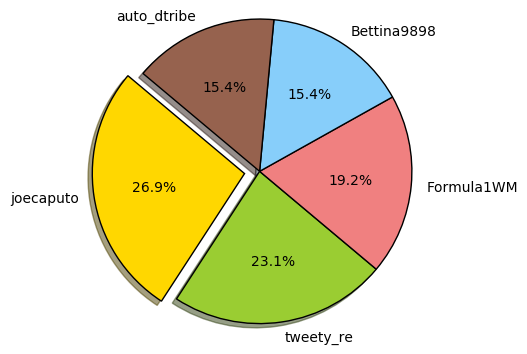

-------------------------------------------
Time: 2017-04-30 12:55:00
-------------------------------------------
Number of tweets this batch: 6

-------------------------------------------
Time: 2017-04-30 12:55:00
-------------------------------------------
2017-04-30 12:41:17
2017-04-30 12:41:17
2017-04-30 12:41:17
2017-04-30 12:41:18
2017-04-30 12:41:17
2017-04-30 12:41:18

-------------------------------------------
Time: 2017-04-30 12:55:00
-------------------------------------------
Harlegator68
MonoplazasF1
lilbatureIII
Iieppi
LauraLeslieF1
benmugu

-------------------------------------------
Time: 2017-04-30 12:55:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('LastWordOnF1', 4)
('exclusivracing', 4)
...



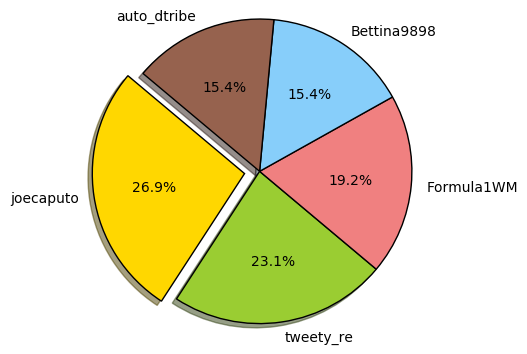

-------------------------------------------
Time: 2017-04-30 12:56:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 12:56:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 12:56:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 12:56:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('LastWordOnF1', 4)
('exclusivracing', 4)
...



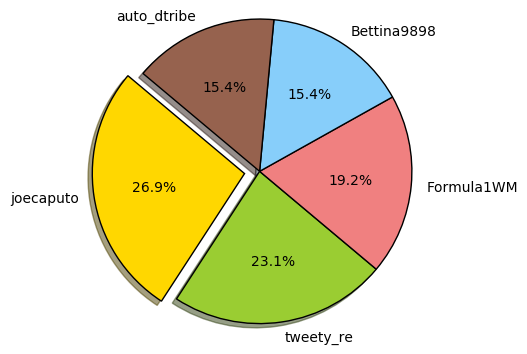

-------------------------------------------
Time: 2017-04-30 12:57:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:57:00
-------------------------------------------
2017-04-30 12:56:00
2017-04-30 12:56:00
2017-04-30 12:56:00
2017-04-30 12:56:00
2017-04-30 12:56:00
2017-04-30 12:56:00
2017-04-30 12:56:00
2017-04-30 12:56:01
2017-04-30 12:56:01
2017-04-30 12:56:01
...

-------------------------------------------
Time: 2017-04-30 12:57:00
-------------------------------------------
JoshHanson18
Bushido_765
jtrawczynski
Monalisazelf
record_mexico
PabloRoca1
MichanFinlandia
Isabelip59
makahiya
Yucker90
...

-------------------------------------------
Time: 2017-04-30 12:57:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Formula1WM', 5)
('LastWordOnF1', 4)
('exclusivracing', 4)
...



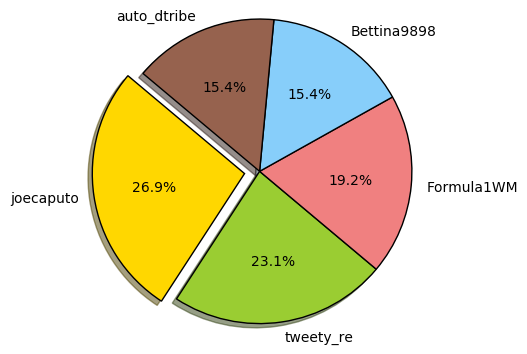

-------------------------------------------
Time: 2017-04-30 12:58:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:58:00
-------------------------------------------
2017-04-30 12:56:01
2017-04-30 12:56:02
2017-04-30 12:56:02
2017-04-30 12:56:02
2017-04-30 12:56:02
2017-04-30 12:56:02
2017-04-30 12:56:02
2017-04-30 12:56:02
2017-04-30 12:56:03
2017-04-30 12:56:03
...

-------------------------------------------
Time: 2017-04-30 12:58:00
-------------------------------------------
AlanRamrez3
F1_Madness
Bettina9898
SenaRin1007
f1enestadopuro
joseangelaragon
SkySport
Marcello_FRB
autosprintLIVE
Jimmy_Manna
...

-------------------------------------------
Time: 2017-04-30 12:58:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Bettina9898', 5)
('F1_Madness', 5)
('Formula1WM', 5)
...



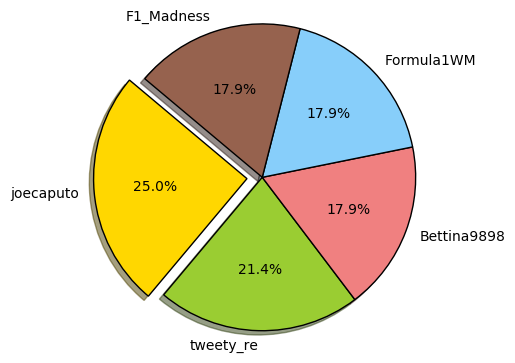

-------------------------------------------
Time: 2017-04-30 12:59:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 12:59:00
-------------------------------------------
2017-04-30 12:56:03
2017-04-30 12:56:03
2017-04-30 12:56:03
2017-04-30 12:56:03
2017-04-30 12:56:04
2017-04-30 12:56:04
2017-04-30 12:56:04
2017-04-30 12:56:04
2017-04-30 12:56:04
2017-04-30 12:56:04
...

-------------------------------------------
Time: 2017-04-30 12:59:00
-------------------------------------------
carvajavo
Oasisantonio
Christian_ADR1
MG__Racing
crbest
Tetr4ctisSrl
t11sK50Mx4HZyCk
ClauParedes4
FimDoGrid
EduardoCoutoRj
...

-------------------------------------------
Time: 2017-04-30 12:59:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 5)
('Bettina9898', 5)
('Formula1WM', 5)
...



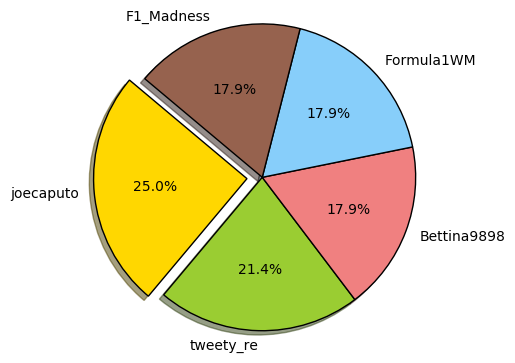

-------------------------------------------
Time: 2017-04-30 13:00:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 13:00:00
-------------------------------------------
2017-04-30 12:56:05
2017-04-30 12:56:05
2017-04-30 12:56:05
2017-04-30 12:56:05
2017-04-30 12:56:05
2017-04-30 12:56:05
2017-04-30 12:56:06
2017-04-30 12:56:06
2017-04-30 12:56:06
2017-04-30 12:56:06
...

-------------------------------------------
Time: 2017-04-30 13:00:00
-------------------------------------------
AbsChile
jmah18
Bettina9898
exclusivracing
danniiieeelllle
Doollyor
DjKrYsTaL
FansOfKR
AOR_Saffzo
Mikrowave
...

-------------------------------------------
Time: 2017-04-30 13:00:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Bettina9898', 6)
('exclusivracing', 5)
('F1_Madness', 5)
...



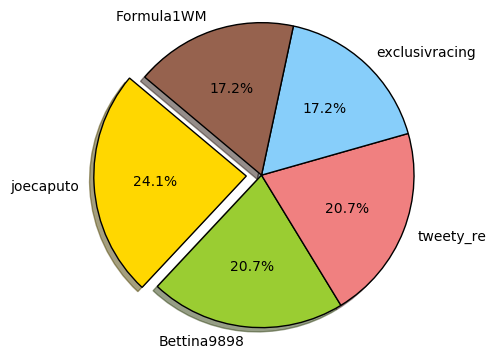

-------------------------------------------
Time: 2017-04-30 13:01:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 13:01:00
-------------------------------------------
2017-04-30 12:56:07
2017-04-30 12:56:07
2017-04-30 12:56:07
2017-04-30 12:56:08
2017-04-30 12:56:08
2017-04-30 12:56:08
2017-04-30 12:56:08
2017-04-30 12:56:08
2017-04-30 12:56:08
2017-04-30 12:56:08
...

-------------------------------------------
Time: 2017-04-30 13:01:00
-------------------------------------------
janet_cutts
TheObtusa
ClauParedes4
MrApalacios
wh0ischloe
HondaJP_Live
yuki8669
_Imagination22
_Leomet
ChealWhat
...

-------------------------------------------
Time: 2017-04-30 13:01:00
-------------------------------------------
('joecaputo', 7)
('tweety_re', 6)
('Bettina9898', 6)
('exclusivracing', 5)
('F1_Madness', 5)
...



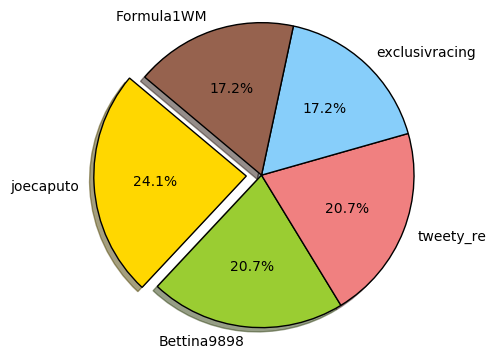

-------------------------------------------
Time: 2017-04-30 13:02:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 13:02:00
-------------------------------------------
2017-04-30 12:56:09
2017-04-30 12:56:09
2017-04-30 12:56:09
2017-04-30 12:56:10
2017-04-30 12:56:10
2017-04-30 12:56:10
2017-04-30 12:56:10
2017-04-30 12:56:10
2017-04-30 12:56:10
2017-04-30 12:56:11
...

-------------------------------------------
Time: 2017-04-30 13:02:00
-------------------------------------------
Eliaslauda
IIalfreII
KeithMehaffey
Bettina9898
Chelsea050214
ClauParedes4
cor_braun
StorkPatrick
weikai615
_avvocato
...

-------------------------------------------
Time: 2017-04-30 13:02:00
-------------------------------------------
('Bettina9898', 7)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 5)
('exclusivracing', 5)
...



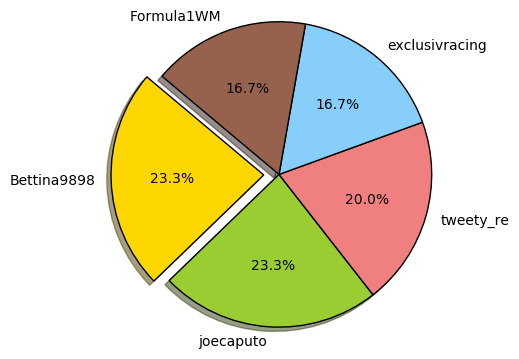

-------------------------------------------
Time: 2017-04-30 13:03:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 13:03:00
-------------------------------------------
2017-04-30 12:56:11
2017-04-30 12:56:11
2017-04-30 12:56:11
2017-04-30 12:56:12
2017-04-30 12:56:12
2017-04-30 12:56:12
2017-04-30 12:56:12
2017-04-30 12:56:12
2017-04-30 12:56:12
2017-04-30 12:56:12
...

-------------------------------------------
Time: 2017-04-30 13:03:00
-------------------------------------------
Haziq44_
mirmidonas1
deepalir
quakerstate_mx
IndyDepre
sunnyboytande
Zaslon_SVR
ruchasharma
elnegropalma141
ArcaKiros
...

-------------------------------------------
Time: 2017-04-30 13:03:00
-------------------------------------------
('Bettina9898', 7)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 5)
('exclusivracing', 5)
...



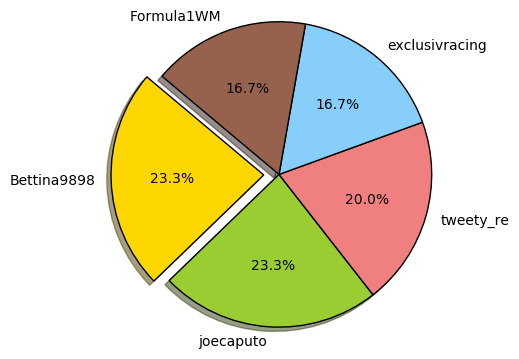

-------------------------------------------
Time: 2017-04-30 13:04:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 13:04:00
-------------------------------------------
2017-04-30 12:56:12
2017-04-30 12:56:13
2017-04-30 12:56:13
2017-04-30 12:56:13
2017-04-30 12:56:13
2017-04-30 12:56:13
2017-04-30 12:56:13
2017-04-30 12:56:13
2017-04-30 12:56:14
2017-04-30 12:56:14
...

-------------------------------------------
Time: 2017-04-30 13:04:00
-------------------------------------------
wtf1official
HeriMiguel
mrc037
SimonGBrooks
Bahatism
my_roof
marcomadeiro
_avvocato
Bettina9898
raqueltdi
...

-------------------------------------------
Time: 2017-04-30 13:04:00
-------------------------------------------
('Bettina9898', 8)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 5)
('exclusivracing', 5)
...



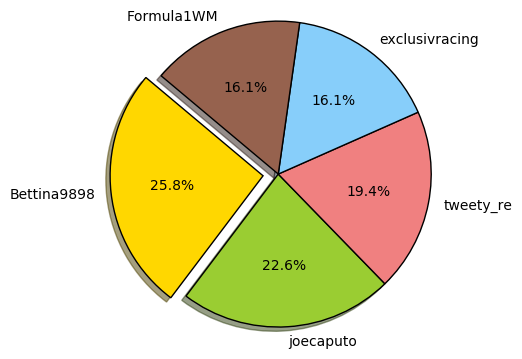

-------------------------------------------
Time: 2017-04-30 13:05:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 13:05:00
-------------------------------------------
2017-04-30 12:56:14
2017-04-30 12:56:14
2017-04-30 12:56:14
2017-04-30 12:56:15
2017-04-30 12:56:15
2017-04-30 12:56:15
2017-04-30 12:56:15
2017-04-30 12:56:15
2017-04-30 12:56:15
2017-04-30 12:56:16
...

-------------------------------------------
Time: 2017-04-30 13:05:00
-------------------------------------------
TheObtusa
500_nozomi
johnmcgrath10
jesscorbinBKS
ariemeijer
MissJadeLeighC
PitCrew_Online
Selfieton
frecklescheco
santicode1
...

-------------------------------------------
Time: 2017-04-30 13:05:00
-------------------------------------------
('Bettina9898', 8)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 5)
('exclusivracing', 5)
...



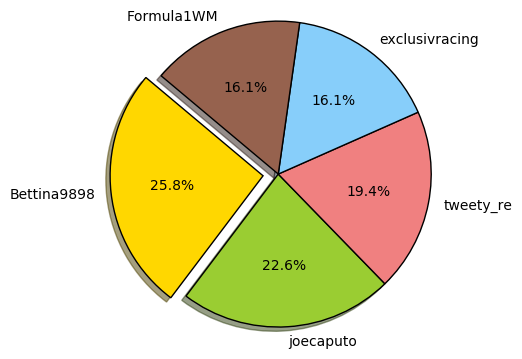

-------------------------------------------
Time: 2017-04-30 13:06:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 13:06:00
-------------------------------------------
2017-04-30 12:56:16
2017-04-30 12:56:16
2017-04-30 12:56:16
2017-04-30 12:56:16
2017-04-30 12:56:16
2017-04-30 12:56:16
2017-04-30 12:56:16
2017-04-30 12:56:16
2017-04-30 12:56:16
2017-04-30 12:56:17
...

-------------------------------------------
Time: 2017-04-30 13:06:00
-------------------------------------------
braccialer
MarinaGironS
rubenike_94
zeroitr
BougonCamille
tecnicaformula1
seitancito
zerothrottle
autosprintLIVE
_avvocato
...

-------------------------------------------
Time: 2017-04-30 13:06:00
-------------------------------------------
('Bettina9898', 8)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 5)
('exclusivracing', 5)
...



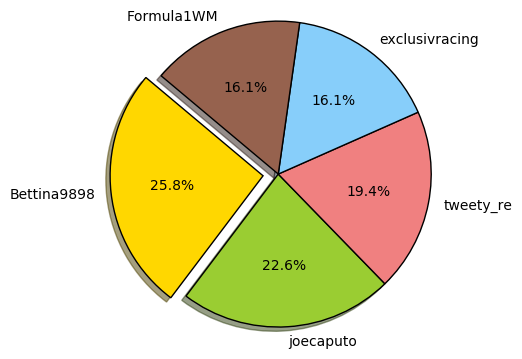

-------------------------------------------
Time: 2017-04-30 13:07:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 13:07:00
-------------------------------------------
2017-04-30 12:56:17
2017-04-30 12:56:17
2017-04-30 12:56:17
2017-04-30 12:56:17
2017-04-30 12:56:17
2017-04-30 12:56:17
2017-04-30 12:56:17
2017-04-30 12:56:17
2017-04-30 12:56:17
2017-04-30 12:56:17
...

-------------------------------------------
Time: 2017-04-30 13:07:00
-------------------------------------------
mundof1brasil
CTVGER
Bettina9898
Louis00000enC
GerardoManiF1
svetformulelive
Alfa_Tipo115_12
f1enestadopuro
Christopher_ngt
oscaroswald
...

-------------------------------------------
Time: 2017-04-30 13:07:00
-------------------------------------------
('Bettina9898', 9)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 5)
('exclusivracing', 5)
...



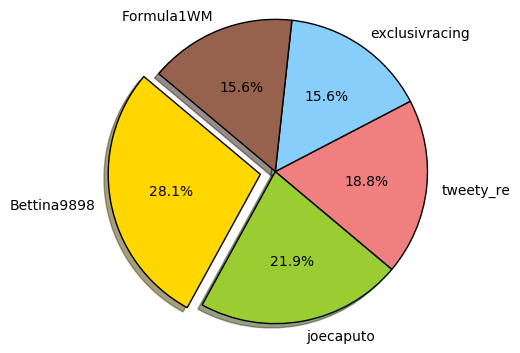

-------------------------------------------
Time: 2017-04-30 13:08:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 13:08:00
-------------------------------------------
2017-04-30 12:56:17
2017-04-30 12:56:17
2017-04-30 12:56:17
2017-04-30 12:56:18
2017-04-30 12:56:18
2017-04-30 12:56:18
2017-04-30 12:56:18
2017-04-30 12:56:18
2017-04-30 12:56:18
2017-04-30 12:56:18
...

-------------------------------------------
Time: 2017-04-30 13:08:00
-------------------------------------------
mikadoors
ScuderiaFerrari
cmnbmg
MatheusLcio
Riki2107
LanceStrollFans
WyattsDecay
ActiveKritizen
Rob9Lewandowski
NascarLiveITA
...

-------------------------------------------
Time: 2017-04-30 13:08:00
-------------------------------------------
('Bettina9898', 9)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 5)
('exclusivracing', 5)
...



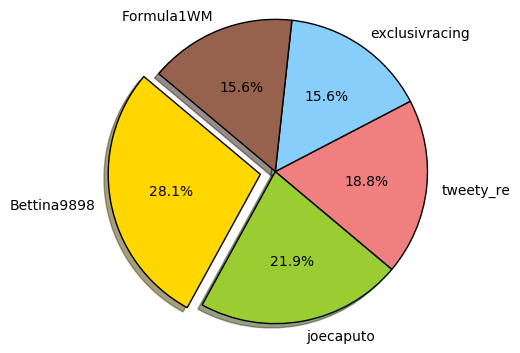

-------------------------------------------
Time: 2017-04-30 13:09:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 13:09:00
-------------------------------------------
2017-04-30 12:56:19
2017-04-30 12:56:18
2017-04-30 12:56:19
2017-04-30 12:56:19
2017-04-30 12:56:19
2017-04-30 12:56:19
2017-04-30 12:56:19
2017-04-30 12:56:19
2017-04-30 12:56:19
2017-04-30 12:56:19
...

-------------------------------------------
Time: 2017-04-30 13:09:00
-------------------------------------------
ricardobragass
Frankvanwijk
ClauParedes4
DaveJamesOnAir
BenTjepkema
AedoArteaga
sdhutia123
Secteur_F1
Bettina9898
9vladmor8
...

-------------------------------------------
Time: 2017-04-30 13:09:00
-------------------------------------------
('Bettina9898', 10)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 5)
('exclusivracing', 5)
...



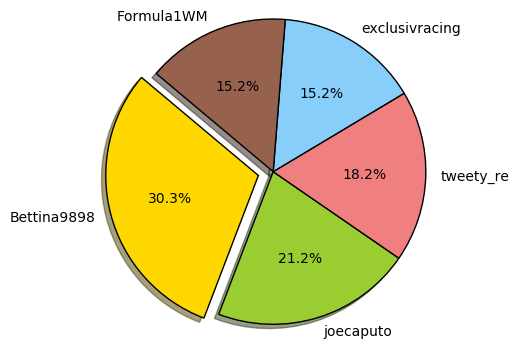

-------------------------------------------
Time: 2017-04-30 13:10:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 13:10:00
-------------------------------------------
2017-04-30 12:56:20
2017-04-30 12:56:21
2017-04-30 12:56:21
2017-04-30 12:56:21
2017-04-30 12:56:21
2017-04-30 12:56:21
2017-04-30 12:56:21
2017-04-30 12:56:22
2017-04-30 12:56:22
2017-04-30 12:56:22
...

-------------------------------------------
Time: 2017-04-30 13:10:00
-------------------------------------------
zoonmattau
BedroomGuitars
koda0105
f1fanaticlive
GeanParra
mgranig
batuomo
Bettina9898
uncannyale
supermxy
...

-------------------------------------------
Time: 2017-04-30 13:10:00
-------------------------------------------
('Bettina9898', 11)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 5)
('exclusivracing', 5)
...



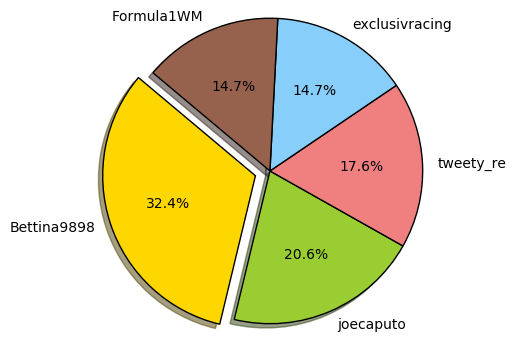

-------------------------------------------
Time: 2017-04-30 13:11:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 13:11:00
-------------------------------------------
2017-04-30 12:56:22
2017-04-30 12:56:22
2017-04-30 12:56:22
2017-04-30 12:56:22
2017-04-30 12:56:22
2017-04-30 12:56:21
2017-04-30 12:56:22
2017-04-30 12:56:23
2017-04-30 12:56:23
2017-04-30 12:56:23
...

-------------------------------------------
Time: 2017-04-30 13:11:00
-------------------------------------------
ClauParedes4
y2jluca
F1_Madness
ppynns
vssanghera
barros_maximus
yggdranix
MatheusLcio
Bushido_765
Motorz_jp
...

-------------------------------------------
Time: 2017-04-30 13:11:00
-------------------------------------------
('Bettina9898', 11)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 6)
('exclusivracing', 5)
...



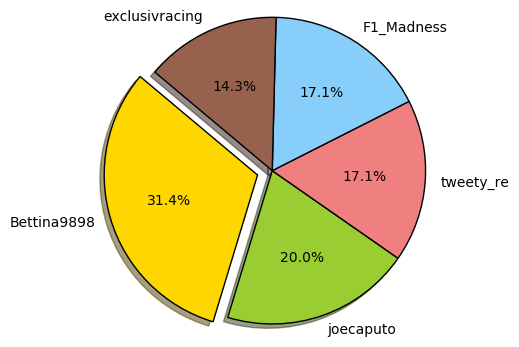

-------------------------------------------
Time: 2017-04-30 13:12:00
-------------------------------------------
Number of tweets this batch: 10

-------------------------------------------
Time: 2017-04-30 13:12:00
-------------------------------------------
2017-04-30 13:11:09
2017-04-30 13:11:09
2017-04-30 13:11:09
2017-04-30 13:11:10
2017-04-30 13:11:10
2017-04-30 13:11:10
2017-04-30 13:11:10
2017-04-30 13:11:10
2017-04-30 13:11:10
2017-04-30 13:11:10

-------------------------------------------
Time: 2017-04-30 13:12:00
-------------------------------------------
TheMillsy79
GlamVampire69
NoticiasVnzl
jgrvilla
andrepsf1
IMeteorainI
DBDeiman
znnn84
Peercys2
akumapablo

-------------------------------------------
Time: 2017-04-30 13:12:00
-------------------------------------------
('Bettina9898', 11)
('joecaputo', 7)
('F1_Madness', 6)
('tweety_re', 6)
('exclusivracing', 5)
...



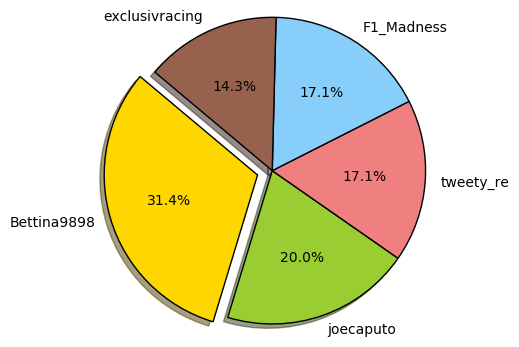

-------------------------------------------
Time: 2017-04-30 13:13:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 13:13:00
-------------------------------------------
2017-04-30 13:11:10
2017-04-30 13:11:10
2017-04-30 13:11:10
2017-04-30 13:11:11
2017-04-30 13:11:11
2017-04-30 13:11:11
2017-04-30 13:11:11
2017-04-30 13:11:11
2017-04-30 13:11:11
2017-04-30 13:11:11
...

-------------------------------------------
Time: 2017-04-30 13:13:00
-------------------------------------------
Sahilsook5
Carlomrtz
ProChaoticHD
mentresfiorisci
sleepingwmoon
lordzeroist
genaldrra
Thabo09
dreakero2222
StoffsCar
...

-------------------------------------------
Time: 2017-04-30 13:13:00
-------------------------------------------
('Bettina9898', 11)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 6)
('exclusivracing', 5)
...



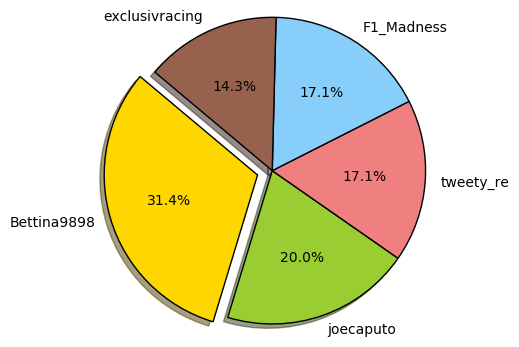

-------------------------------------------
Time: 2017-04-30 13:14:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 13:14:00
-------------------------------------------
2017-04-30 13:11:11
2017-04-30 13:11:11
2017-04-30 13:11:12
2017-04-30 13:11:12
2017-04-30 13:11:12
2017-04-30 13:11:12
2017-04-30 13:11:12
2017-04-30 13:11:12
2017-04-30 13:11:12
2017-04-30 13:11:12
...

-------------------------------------------
Time: 2017-04-30 13:14:00
-------------------------------------------
franciscolf_98
Joe_Turney
rieraF1
leo4july
UitalloRss
marcosF94M
MrgrtMaxine
PRL_Stevie
Susana_Uxia
WhySeriously_
...

-------------------------------------------
Time: 2017-04-30 13:14:00
-------------------------------------------
('Bettina9898', 11)
('joecaputo', 7)
('F1_Madness', 6)
('tweety_re', 6)
('exclusivracing', 5)
...



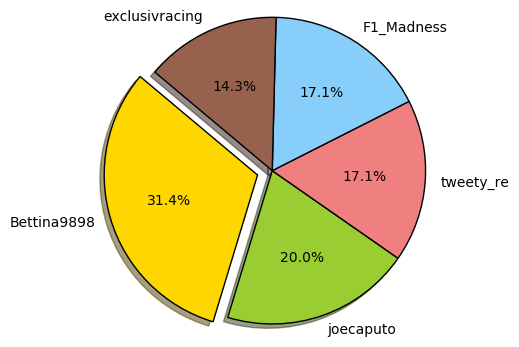

-------------------------------------------
Time: 2017-04-30 13:15:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 13:15:00
-------------------------------------------
2017-04-30 13:11:13
2017-04-30 13:11:13
2017-04-30 13:11:13
2017-04-30 13:11:13
2017-04-30 13:11:13
2017-04-30 13:11:13
2017-04-30 13:11:13
2017-04-30 13:11:13
2017-04-30 13:11:13
2017-04-30 13:11:13
...

-------------------------------------------
Time: 2017-04-30 13:15:00
-------------------------------------------
alex_ciudadreal
daragefa
Auwalxx
solomone45
c_t_scan
RStripsComic
eyooekpo
WilliamFlorez
posdkf
LaKarythe
...

-------------------------------------------
Time: 2017-04-30 13:15:00
-------------------------------------------
('Bettina9898', 11)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 6)
('exclusivracing', 5)
...



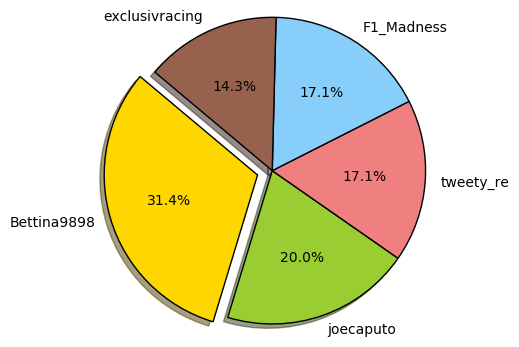

-------------------------------------------
Time: 2017-04-30 13:16:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 13:16:00
-------------------------------------------
2017-04-30 13:11:13
2017-04-30 13:11:14
2017-04-30 13:11:14
2017-04-30 13:11:14
2017-04-30 13:11:14
2017-04-30 13:11:14
2017-04-30 13:11:14
2017-04-30 13:11:14
2017-04-30 13:11:14
2017-04-30 13:11:14
...

-------------------------------------------
Time: 2017-04-30 13:16:00
-------------------------------------------
GlamVampire69
herckaaa
VickySchneiders
babifranzin
laletsos
vaquerooo89
SerenaRF1
DjAspen1
AnAngelOfDeath
AnonymoonKheir
...

-------------------------------------------
Time: 2017-04-30 13:16:00
-------------------------------------------
('Bettina9898', 11)
('joecaputo', 7)
('F1_Madness', 6)
('tweety_re', 6)
('exclusivracing', 5)
...



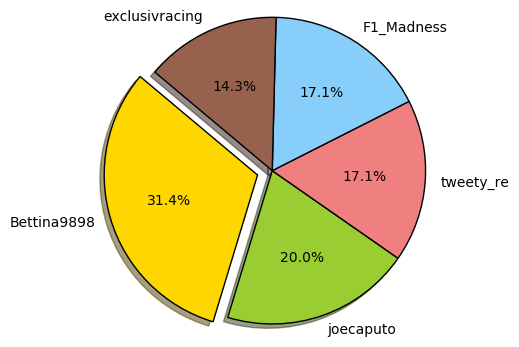

-------------------------------------------
Time: 2017-04-30 13:17:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 13:17:00
-------------------------------------------
2017-04-30 13:11:15
2017-04-30 13:11:15
2017-04-30 13:11:14
2017-04-30 13:11:15
2017-04-30 13:11:15
2017-04-30 13:11:15
2017-04-30 13:11:15
2017-04-30 13:11:15
2017-04-30 13:11:15
2017-04-30 13:11:16
...

-------------------------------------------
Time: 2017-04-30 13:17:00
-------------------------------------------
mutu12
jan_svs
SakuraiMichi
SoyMotor
sdhutia123
velivicivokke
SebxIzumixKF2
MarielyRC
tatsu_ge
p2pc2e
...

-------------------------------------------
Time: 2017-04-30 13:17:00
-------------------------------------------
('Bettina9898', 11)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 6)
('exclusivracing', 5)
...



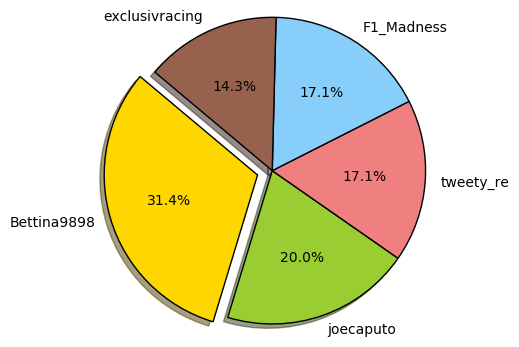

-------------------------------------------
Time: 2017-04-30 13:18:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 13:18:00
-------------------------------------------
2017-04-30 13:11:16
2017-04-30 13:11:16
2017-04-30 13:11:16
2017-04-30 13:11:16
2017-04-30 13:11:16
2017-04-30 13:11:16
2017-04-30 13:11:16
2017-04-30 13:11:17
2017-04-30 13:11:16
2017-04-30 13:11:17
...

-------------------------------------------
Time: 2017-04-30 13:18:00
-------------------------------------------
Xxvaleska
colomorales
charwillxams
lightsonaukje
pro_motors74
Bea___gallo
manuvfm97
skopal
yawnoctrm
samhallsport
...

-------------------------------------------
Time: 2017-04-30 13:18:00
-------------------------------------------
('Bettina9898', 11)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 6)
('exclusivracing', 5)
...



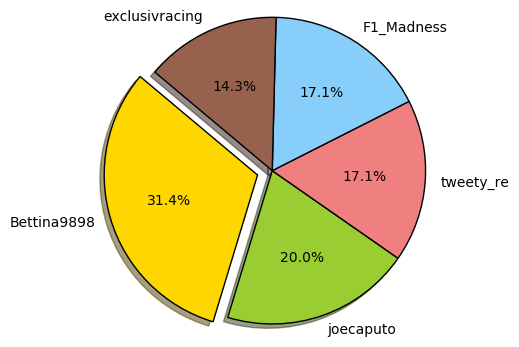

-------------------------------------------
Time: 2017-04-30 13:19:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 13:19:00
-------------------------------------------
2017-04-30 13:11:17
2017-04-30 13:11:17
2017-04-30 13:11:17
2017-04-30 13:11:17
2017-04-30 13:11:17
2017-04-30 13:11:17
2017-04-30 13:11:17
2017-04-30 13:11:17
2017-04-30 13:11:17
2017-04-30 13:11:17
...

-------------------------------------------
Time: 2017-04-30 13:19:00
-------------------------------------------
ex_family0121
sweetlikedream
CoandaF1
JX2001
Pcreepers
BiaBalestieri
gafarshobaloju
rshamaker
majifi_72
bbcf1
...

-------------------------------------------
Time: 2017-04-30 13:19:00
-------------------------------------------
('Bettina9898', 11)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 6)
('exclusivracing', 5)
...



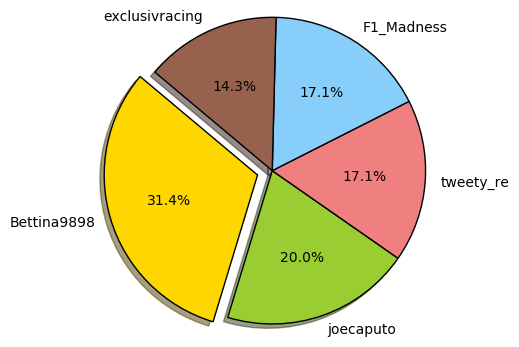

-------------------------------------------
Time: 2017-04-30 13:20:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 13:20:00
-------------------------------------------
2017-04-30 13:11:17
2017-04-30 13:11:18
2017-04-30 13:11:18
2017-04-30 13:11:18
2017-04-30 13:11:18
2017-04-30 13:11:18
2017-04-30 13:11:18
2017-04-30 13:11:17
2017-04-30 13:11:18
2017-04-30 13:11:18
...

-------------------------------------------
Time: 2017-04-30 13:20:00
-------------------------------------------
xDaisyG
JLB_Nissa
PimSterenberg
kamboJia
EaArlotta
harjotmankoo
saileshsf
KM20RACING
LaBandaRoja14
ElatedPrims
...

-------------------------------------------
Time: 2017-04-30 13:20:00
-------------------------------------------
('Bettina9898', 11)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 6)
('exclusivracing', 5)
...



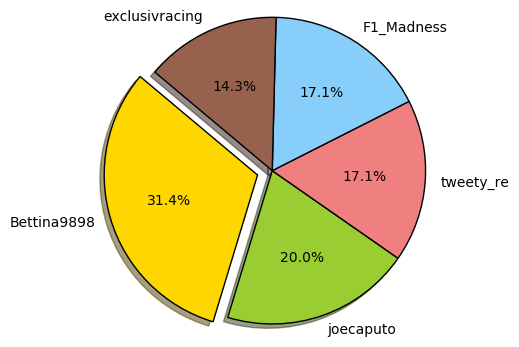

-------------------------------------------
Time: 2017-04-30 13:21:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 13:21:00
-------------------------------------------
2017-04-30 13:11:18
2017-04-30 13:11:18
2017-04-30 13:11:19
2017-04-30 13:11:18
2017-04-30 13:11:19
2017-04-30 13:11:19
2017-04-30 13:11:19
2017-04-30 13:11:19
2017-04-30 13:11:19
2017-04-30 13:11:19
...

-------------------------------------------
Time: 2017-04-30 13:21:00
-------------------------------------------
_h1dro
BWOAHF1
MKimiste
TomGreeny1993
ArianitShabani7
RetroRL_
ChrissieHotspur
Javinive
moon_and_saturn
vaso1968
...

-------------------------------------------
Time: 2017-04-30 13:21:00
-------------------------------------------
('Bettina9898', 11)
('joecaputo', 7)
('F1_Madness', 6)
('tweety_re', 6)
('exclusivracing', 5)
...



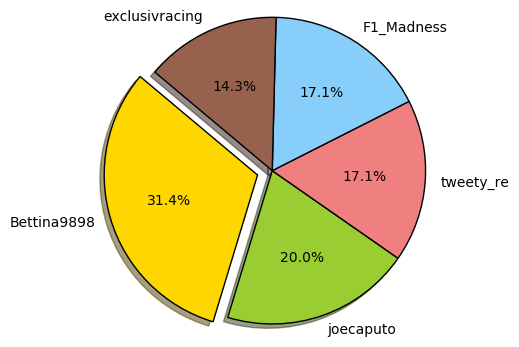

-------------------------------------------
Time: 2017-04-30 13:22:00
-------------------------------------------
Number of tweets this batch: 8

-------------------------------------------
Time: 2017-04-30 13:22:00
-------------------------------------------
2017-04-30 13:11:19
2017-04-30 13:11:19
2017-04-30 13:11:19
2017-04-30 13:11:19
2017-04-30 13:11:19
2017-04-30 13:11:19
2017-04-30 13:11:19
2017-04-30 13:11:19

-------------------------------------------
Time: 2017-04-30 13:22:00
-------------------------------------------
HchZerocham
Bettina9898
REVOLP
johnny_johnsen
bobcinyamepi
wilsonferreira_
EroticaPornStar
halmessa

-------------------------------------------
Time: 2017-04-30 13:22:00
-------------------------------------------
('Bettina9898', 12)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 6)
('exclusivracing', 5)
...



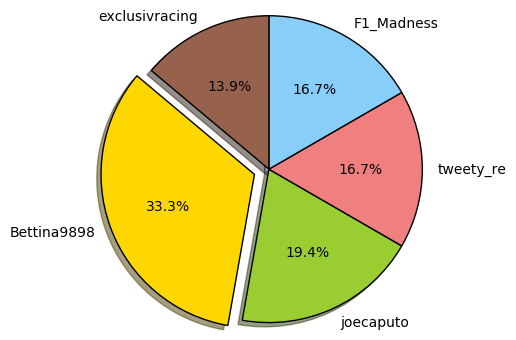

-------------------------------------------
Time: 2017-04-30 13:23:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 13:23:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 13:23:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 13:23:00
-------------------------------------------
('Bettina9898', 12)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 6)
('exclusivracing', 5)
...



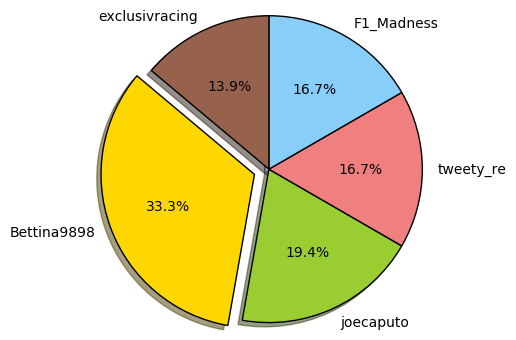

-------------------------------------------
Time: 2017-04-30 13:24:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 13:24:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 13:24:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 13:24:00
-------------------------------------------
('Bettina9898', 12)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 6)
('exclusivracing', 5)
...



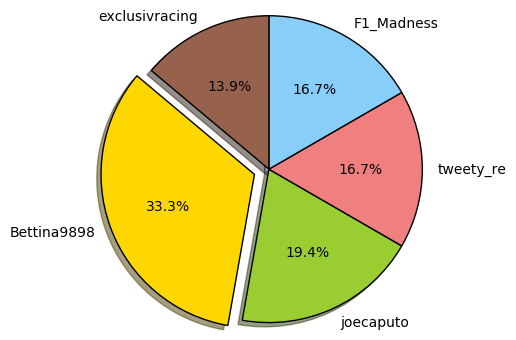

-------------------------------------------
Time: 2017-04-30 13:25:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 13:25:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 13:25:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 13:25:00
-------------------------------------------
('Bettina9898', 12)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 6)
('exclusivracing', 5)
...



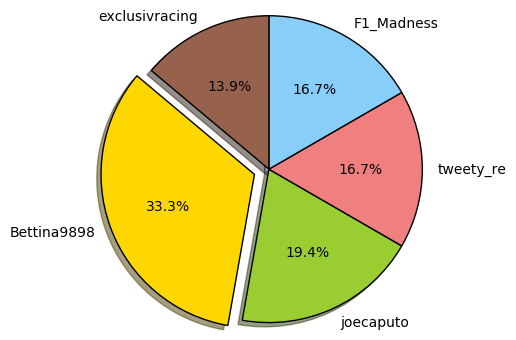

-------------------------------------------
Time: 2017-04-30 13:26:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 13:26:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 13:26:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 13:26:00
-------------------------------------------
('Bettina9898', 12)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 6)
('exclusivracing', 5)
...



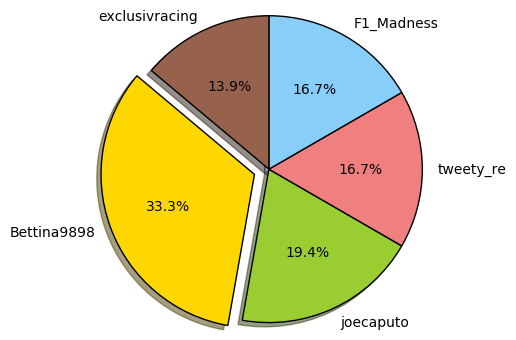

-------------------------------------------
Time: 2017-04-30 13:27:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 13:27:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 13:27:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 13:27:00
-------------------------------------------
('Bettina9898', 12)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 6)
('exclusivracing', 5)
...



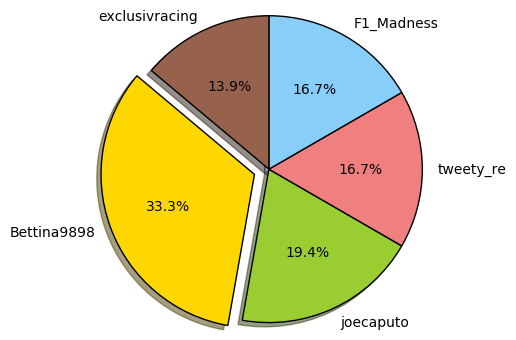

-------------------------------------------
Time: 2017-04-30 13:28:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 13:28:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 13:28:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 13:28:00
-------------------------------------------
('Bettina9898', 12)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 6)
('exclusivracing', 5)
...



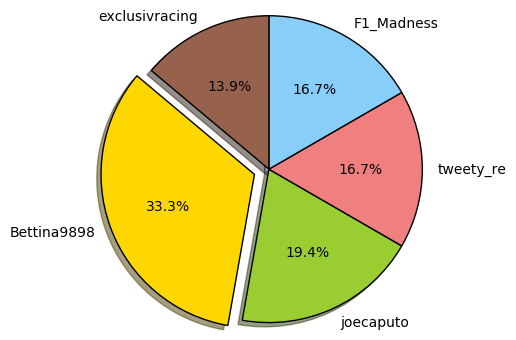

-------------------------------------------
Time: 2017-04-30 13:29:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 13:29:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 13:29:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 13:29:00
-------------------------------------------
('Bettina9898', 12)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 6)
('exclusivracing', 5)
...



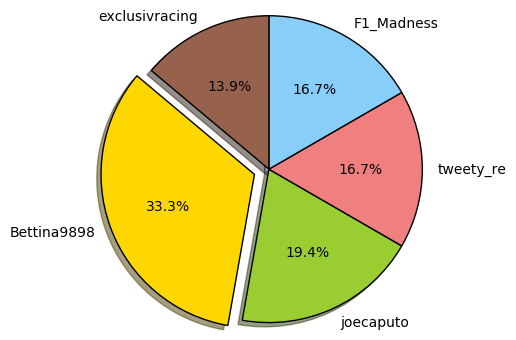

-------------------------------------------
Time: 2017-04-30 13:30:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 13:30:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 13:30:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 13:30:00
-------------------------------------------
('Bettina9898', 12)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 6)
('exclusivracing', 5)
...



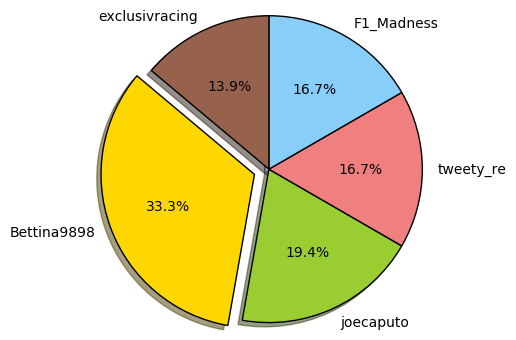

-------------------------------------------
Time: 2017-04-30 13:31:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 13:31:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 13:31:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 13:31:00
-------------------------------------------
('Bettina9898', 12)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 6)
('exclusivracing', 5)
...



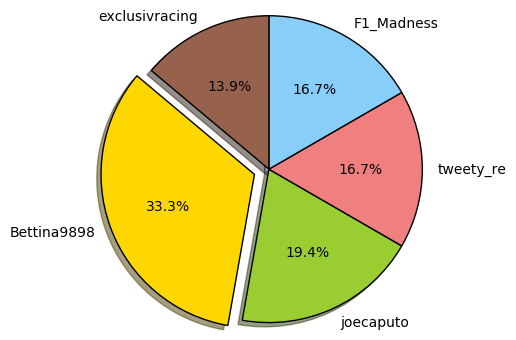

-------------------------------------------
Time: 2017-04-30 13:32:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 13:32:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 13:32:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 13:32:00
-------------------------------------------
('Bettina9898', 12)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 6)
('exclusivracing', 5)
...



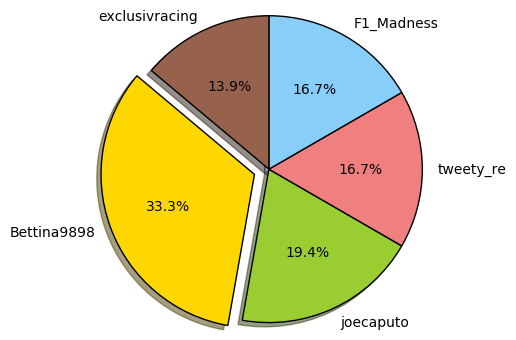

-------------------------------------------
Time: 2017-04-30 13:33:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 13:33:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 13:33:00
-------------------------------------------

-------------------------------------------
Time: 2017-04-30 13:33:00
-------------------------------------------
('Bettina9898', 12)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 6)
('exclusivracing', 5)
...



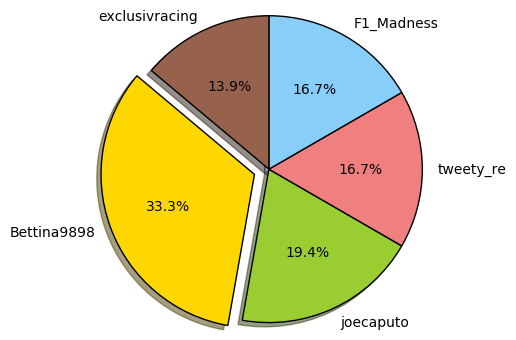

-------------------------------------------
Time: 2017-04-30 13:34:00
-------------------------------------------
Number of tweets this batch: 9

-------------------------------------------
Time: 2017-04-30 13:34:00
-------------------------------------------
2017-04-30 13:33:18
2017-04-30 13:33:19
2017-04-30 13:33:19
2017-04-30 13:33:19
2017-04-30 13:33:19
2017-04-30 13:33:19
2017-04-30 13:33:19
2017-04-30 13:33:19
2017-04-30 13:33:19

-------------------------------------------
Time: 2017-04-30 13:34:00
-------------------------------------------
robert_wallbank
eduardoasmf
Monalisazelf
LaurenceTaylor6
thenach
AitzeYT
Oussam357
RiccardoRespano
Sentimentcule99

-------------------------------------------
Time: 2017-04-30 13:34:00
-------------------------------------------
('Bettina9898', 12)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 6)
('exclusivracing', 5)
...



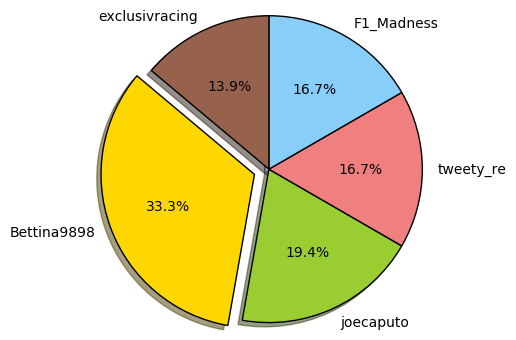

-------------------------------------------
Time: 2017-04-30 13:35:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 13:35:00
-------------------------------------------
2017-04-30 13:33:20
2017-04-30 13:33:20
2017-04-30 13:33:20
2017-04-30 13:33:20
2017-04-30 13:33:20
2017-04-30 13:33:20
2017-04-30 13:33:20
2017-04-30 13:33:20
2017-04-30 13:33:20
2017-04-30 13:33:21
...

-------------------------------------------
Time: 2017-04-30 13:35:00
-------------------------------------------
januszcwikla
nickizzlewright
JPN_MS
kellyta_puelpan
Fadil_Shehu
Minicooper45
twa767
KaraboKbmags
zeerke
rachelbbridge
...

-------------------------------------------
Time: 2017-04-30 13:35:00
-------------------------------------------
('Bettina9898', 12)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 6)
('exclusivracing', 5)
...



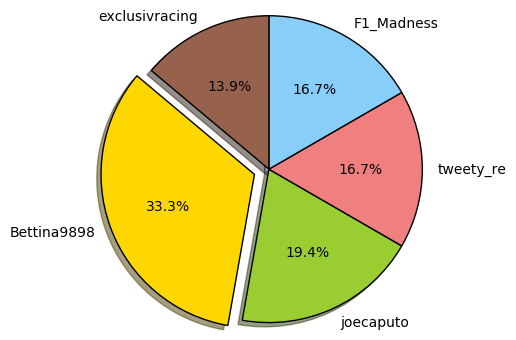

-------------------------------------------
Time: 2017-04-30 13:36:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 13:36:00
-------------------------------------------
2017-04-30 13:33:21
2017-04-30 13:33:21
2017-04-30 13:33:21
2017-04-30 13:33:21
2017-04-30 13:33:21
2017-04-30 13:33:21
2017-04-30 13:33:21
2017-04-30 13:33:21
2017-04-30 13:33:21
2017-04-30 13:33:22
...

-------------------------------------------
Time: 2017-04-30 13:36:00
-------------------------------------------
AlanRamrez3
Formula1_MotoGP
TotalRacingLive
StevenSportNews
luigicaldo
aadgroenewegen
pippuri
RattersBoner
lamington18
arquitecta
...

-------------------------------------------
Time: 2017-04-30 13:36:00
-------------------------------------------
('Bettina9898', 13)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 6)
('exclusivracing', 5)
...



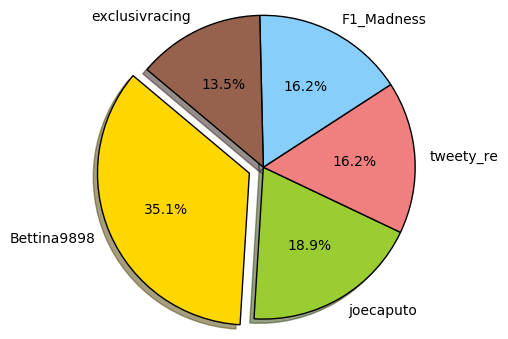

-------------------------------------------
Time: 2017-04-30 13:37:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 13:37:00
-------------------------------------------
2017-04-30 13:33:22
2017-04-30 13:33:22
2017-04-30 13:33:22
2017-04-30 13:33:22
2017-04-30 13:33:23
2017-04-30 13:33:22
2017-04-30 13:33:23
2017-04-30 13:33:23
2017-04-30 13:33:23
2017-04-30 13:33:23
...

-------------------------------------------
Time: 2017-04-30 13:37:00
-------------------------------------------
IvanUlloaOk
jaribruppacher
SirBenG2
ysordc
MrApalacios
itsflynn
wwespnascar424
gianmc2
fecdias
IOBWT
...

-------------------------------------------
Time: 2017-04-30 13:37:00
-------------------------------------------
('Bettina9898', 13)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 6)
('exclusivracing', 5)
...



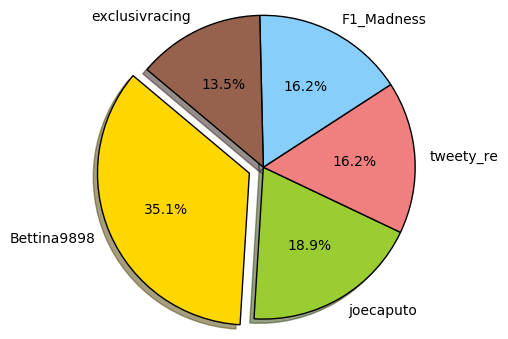

-------------------------------------------
Time: 2017-04-30 13:38:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 13:38:00
-------------------------------------------
2017-04-30 13:33:23
2017-04-30 13:33:23
2017-04-30 13:33:23
2017-04-30 13:33:24
2017-04-30 13:33:24
2017-04-30 13:33:24
2017-04-30 13:33:24
2017-04-30 13:33:24
2017-04-30 13:33:24
2017-04-30 13:33:24
...

-------------------------------------------
Time: 2017-04-30 13:38:00
-------------------------------------------
debispereira
JocelynNugteren
CarloDominicana
KarinBroeders
LightsOutF1Blog
F1racing
safakgokkus
f1lineup
Ofitus21
theequench
...

-------------------------------------------
Time: 2017-04-30 13:38:00
-------------------------------------------
('Bettina9898', 13)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 6)
('exclusivracing', 5)
...



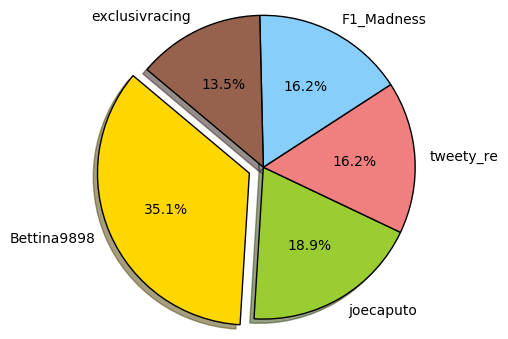

-------------------------------------------
Time: 2017-04-30 13:39:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 13:39:00
-------------------------------------------
2017-04-30 13:33:24
2017-04-30 13:33:24
2017-04-30 13:33:24
2017-04-30 13:33:25
2017-04-30 13:33:25
2017-04-30 13:33:25
2017-04-30 13:33:25
2017-04-30 13:33:25
2017-04-30 13:33:25
2017-04-30 13:33:25
...

-------------------------------------------
Time: 2017-04-30 13:39:00
-------------------------------------------
filipebessa78
ColMotorFans
SteveStevens47
ASR_Nick
PitLane_F1
lisaparvo
mujuru77
SteveLloydF1
ESPNF1
tensporttv
...

-------------------------------------------
Time: 2017-04-30 13:39:00
-------------------------------------------
('Bettina9898', 13)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 6)
('exclusivracing', 5)
...



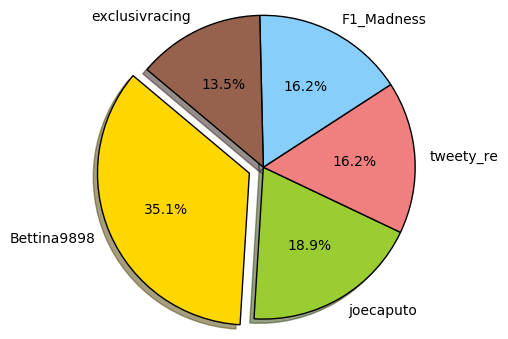

-------------------------------------------
Time: 2017-04-30 13:40:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 13:40:00
-------------------------------------------
2017-04-30 13:33:25
2017-04-30 13:33:26
2017-04-30 13:33:26
2017-04-30 13:33:26
2017-04-30 13:33:26
2017-04-30 13:33:26
2017-04-30 13:33:26
2017-04-30 13:33:26
2017-04-30 13:33:26
2017-04-30 13:33:27
...

-------------------------------------------
Time: 2017-04-30 13:40:00
-------------------------------------------
victorkyb
PurpleSectorGP
vsanmcs
SoyMotor
ArcherMishale
Am_2296
LastWordOnF1
costinjemma
loai_mutabagani
loulou1963xx
...

-------------------------------------------
Time: 2017-04-30 13:40:00
-------------------------------------------
('Bettina9898', 13)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 6)
('LastWordOnF1', 5)
...



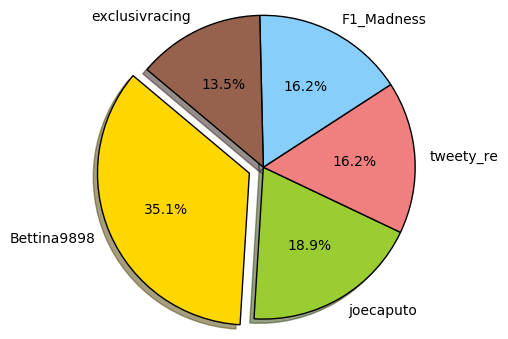

-------------------------------------------
Time: 2017-04-30 13:41:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 13:41:00
-------------------------------------------
2017-04-30 13:33:27
2017-04-30 13:33:27
2017-04-30 13:33:27
2017-04-30 13:33:27
2017-04-30 13:33:27
2017-04-30 13:33:27
2017-04-30 13:33:27
2017-04-30 13:33:27
2017-04-30 13:33:27
2017-04-30 13:33:28
...

-------------------------------------------
Time: 2017-04-30 13:41:00
-------------------------------------------
ilariazusso
Formula1isdrug
Lefistro
Subject_Here
Chia238
autosprintLIVE
F1onNBCSports
Rigocz
EdwarRam
svetformulelive
...

-------------------------------------------
Time: 2017-04-30 13:41:00
-------------------------------------------
('Bettina9898', 13)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 6)
('LastWordOnF1', 5)
...



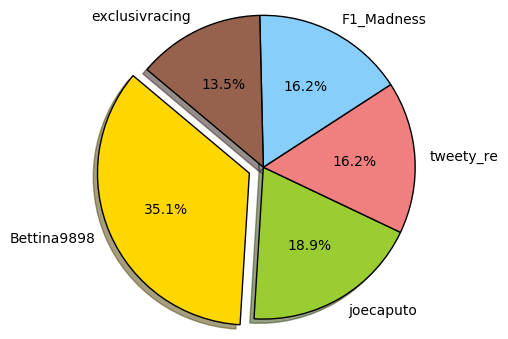

-------------------------------------------
Time: 2017-04-30 13:42:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 13:42:00
-------------------------------------------
2017-04-30 13:33:28
2017-04-30 13:33:27
2017-04-30 13:33:28
2017-04-30 13:33:28
2017-04-30 13:33:28
2017-04-30 13:33:29
2017-04-30 13:33:29
2017-04-30 13:33:29
2017-04-30 13:33:29
2017-04-30 13:33:29
...

-------------------------------------------
Time: 2017-04-30 13:42:00
-------------------------------------------
formulaspy
SaraS_Phoenix
a_rkw_ms
gooner_saad
KarlaaMejia
Sentimentcule99
Mainawathama
FiendKh__xlil
RCRacer65451204
CronopioX
...

-------------------------------------------
Time: 2017-04-30 13:42:00
-------------------------------------------
('Bettina9898', 13)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 6)
('LastWordOnF1', 5)
...



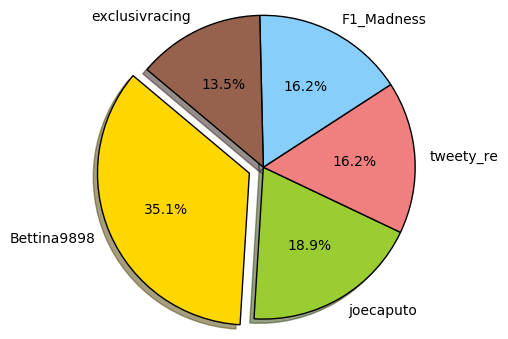

-------------------------------------------
Time: 2017-04-30 13:43:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 13:43:00
-------------------------------------------
2017-04-30 13:33:30
2017-04-30 13:33:30
2017-04-30 13:33:30
2017-04-30 13:33:30
2017-04-30 13:33:30
2017-04-30 13:33:30
2017-04-30 13:33:31
2017-04-30 13:33:31
2017-04-30 13:33:31
2017-04-30 13:33:31
...

-------------------------------------------
Time: 2017-04-30 13:43:00
-------------------------------------------
F1Newsinfo
alexdavenport4
SteveStevens47
ruipii
sleepingwmoon
A_Alonso21
f1couk
IvanUlloaOk
jerrysan5
OmarBozOfficial
...

-------------------------------------------
Time: 2017-04-30 13:43:00
-------------------------------------------
('Bettina9898', 13)
('joecaputo', 7)
('tweety_re', 6)
('F1_Madness', 6)
('LastWordOnF1', 5)
...



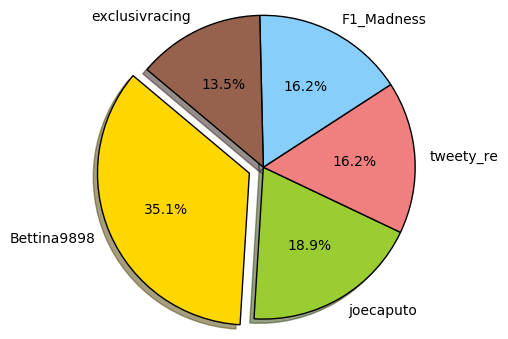

-------------------------------------------
Time: 2017-04-30 13:44:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 13:44:00
-------------------------------------------
2017-04-30 13:33:31
2017-04-30 13:33:31
2017-04-30 13:33:31
2017-04-30 13:33:31
2017-04-30 13:33:32
2017-04-30 13:33:31
2017-04-30 13:33:32
2017-04-30 13:33:32
2017-04-30 13:33:32
2017-04-30 13:33:32
...

-------------------------------------------
Time: 2017-04-30 13:44:00
-------------------------------------------
franciscolf_98
F1grid
rafaelopes10
KeZhen5
RossiELaRossa
ruchasharma
24usamaru
MichaelLamonato
SkySport
dreakero2222
...

-------------------------------------------
Time: 2017-04-30 13:44:00
-------------------------------------------
('Bettina9898', 13)
('F1_Madness', 7)
('joecaputo', 7)
('tweety_re', 6)
('LastWordOnF1', 5)
...



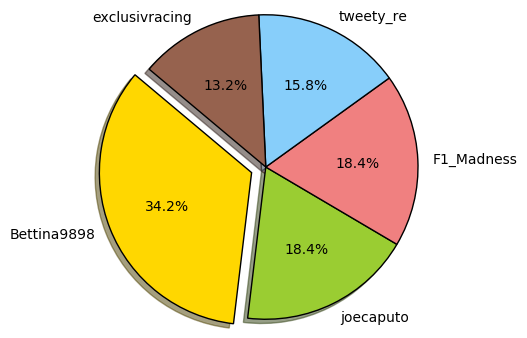

-------------------------------------------
Time: 2017-04-30 13:45:00
-------------------------------------------
Number of tweets this batch: 11

-------------------------------------------
Time: 2017-04-30 13:45:00
-------------------------------------------
2017-04-30 13:33:32
2017-04-30 13:33:32
2017-04-30 13:33:32
2017-04-30 13:33:32
2017-04-30 13:33:32
2017-04-30 13:33:32
2017-04-30 13:33:33
2017-04-30 13:33:32
2017-04-30 13:33:33
2017-04-30 13:33:32
...

-------------------------------------------
Time: 2017-04-30 13:45:00
-------------------------------------------
racharmstrongx
ArturoKyalami
WeillArthur
HchZerocham
JhonnyKovalski
AUSmotive
pinkki14
VamonosdeLargo
Manfredo
lady_gizz
...

-------------------------------------------
Time: 2017-04-30 13:45:00
-------------------------------------------
('Bettina9898', 13)
('F1_Madness', 7)
('joecaputo', 7)
('tweety_re', 6)
('LastWordOnF1', 5)
...



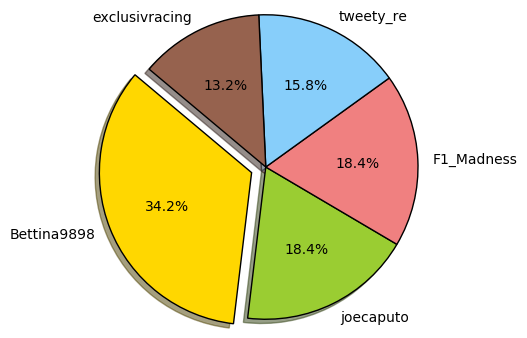

-------------------------------------------
Time: 2017-04-30 13:46:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 13:46:00
-------------------------------------------
2017-04-30 13:33:34
2017-04-30 13:33:34
2017-04-30 13:33:34
2017-04-30 13:33:34
2017-04-30 13:33:33
2017-04-30 13:33:34
2017-04-30 13:33:34
2017-04-30 13:33:34
2017-04-30 13:33:35
2017-04-30 13:33:35
...

-------------------------------------------
Time: 2017-04-30 13:46:00
-------------------------------------------
Esporte_Global
Thiago_tdm76
PitCrew_Online
JenstheGTIfreak
stardastboy01
Retribulation
Jason_Batz
elenagubler_
jschaffer_mbef1
Palo_CTM
...

-------------------------------------------
Time: 2017-04-30 13:46:00
-------------------------------------------
('Bettina9898', 13)
('F1_Madness', 7)
('joecaputo', 7)
('tweety_re', 6)
('LastWordOnF1', 5)
...



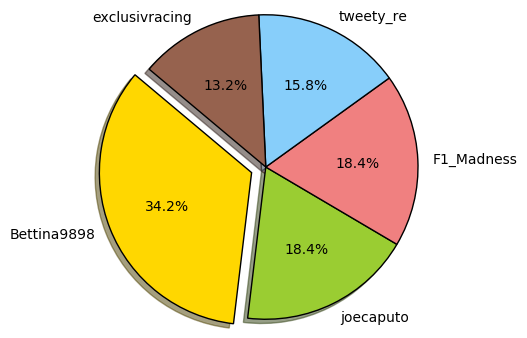

-------------------------------------------
Time: 2017-04-30 13:47:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 13:47:00
-------------------------------------------
2017-04-30 13:33:35
2017-04-30 13:33:35
2017-04-30 13:33:35
2017-04-30 13:33:35
2017-04-30 13:33:35
2017-04-30 13:33:35
2017-04-30 13:33:35
2017-04-30 13:33:35
2017-04-30 13:33:35
2017-04-30 13:33:35
...

-------------------------------------------
Time: 2017-04-30 13:47:00
-------------------------------------------
zerothrottle
rafaelcalha
jhonmotorsport
roty24
mac_ar_on
clape87
_lukmannnnnn
BenBelcher_
MC_Smith22
GiorgioFreschi
...

-------------------------------------------
Time: 2017-04-30 13:47:00
-------------------------------------------
('Bettina9898', 13)
('F1_Madness', 7)
('joecaputo', 7)
('tweety_re', 6)
('LastWordOnF1', 5)
...



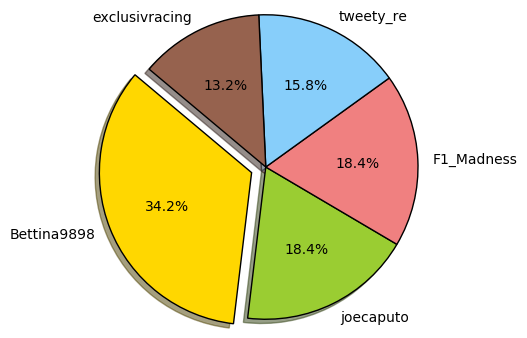

-------------------------------------------
Time: 2017-04-30 13:48:00
-------------------------------------------
Number of tweets this batch: 12

-------------------------------------------
Time: 2017-04-30 13:48:00
-------------------------------------------
2017-04-30 13:33:35
2017-04-30 13:33:36
2017-04-30 13:33:36
2017-04-30 13:33:36
2017-04-30 13:33:36
2017-04-30 13:33:36
2017-04-30 13:33:36
2017-04-30 13:33:36
2017-04-30 13:33:36
2017-04-30 13:33:36
...

-------------------------------------------
Time: 2017-04-30 13:48:00
-------------------------------------------
IvanUlloaOk
MadridMotorS
Mikrowave
masahito0751gm2
KuIkram
rolopemx
MatheusL31
filipebessa78
SPEED
ra_estrada
...

-------------------------------------------
Time: 2017-04-30 13:48:00
-------------------------------------------
('Bettina9898', 13)
('F1_Madness', 7)
('joecaputo', 7)
('tweety_re', 6)
('LastWordOnF1', 5)
...



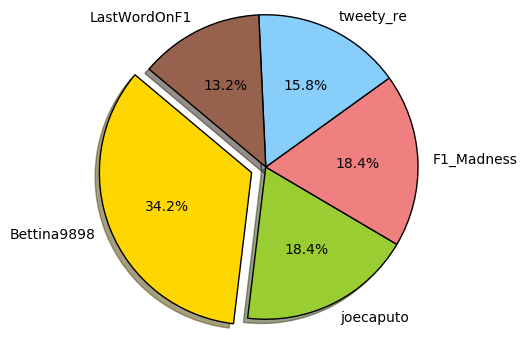

KeyboardInterrupt: 

In [8]:
ssc.start()
ssc.awaitTermination()

El procesamiento se puede detener manualmente con la siguiente línea.

In [9]:
ssc.stop()

Una vez tenemos todos los datos en el fichero de texto, vamos a crear una lista que los contenga todos.

In [10]:
datefile = "dates.txt"
total_tweets = 0
with open(datefile, 'r') as f:
    f.seek(0)
    all_dates = [] 
    for line in f:  
        all_dates.append(line)
        total_tweets = total_tweets + 1

Aprovechamos para calcular el número total de tweets durante todo el streaming.

In [11]:
print("Total tweets: {}".format(total_tweets))

Total tweets: 55651


De nuevo, añadimos una serie de imports para crear una gráfica a partir de los datos obtenidos.

In [12]:
import pandas as pd
import numpy as np
from datetime import datetime 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

El siguiente trozo de código utiliza las librerías pandas y numpy para crear una gráfica en la que se mostrará la frecuencia de tweets durante el intervalo de tiempo analizado usando Spark Streaming.

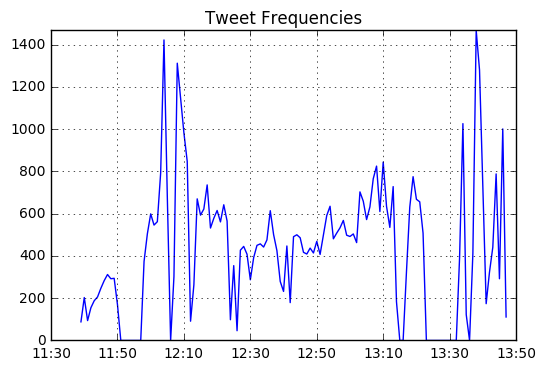

In [13]:
idx = pd.DatetimeIndex(all_dates)
ones = np.ones(len(all_dates))
my_series = pd.Series(ones, index=idx)

# Resampling / bucketing into 1-minute buckets 
per_minute = my_series.resample('1Min').sum().fillna(0) 
     
# Plotting the series 
fig, ax = plt.subplots() 
ax.grid(True) 
ax.set_title("Tweet Frequencies") 
     
hours = mdates.MinuteLocator(interval=20) 
date_formatter = mdates.DateFormatter('%H:%M') 
 
datemin = datetime(2017, 4, 30, 11, 30) 
datemax = datetime(2017, 4, 30, 13, 50)

ax.xaxis.set_major_locator(hours) 
ax.xaxis.set_major_formatter(date_formatter) 
ax.set_xlim(datemin, datemax) 
max_freq = per_minute.max() 
ax.set_ylim(0, max_freq) 
ax.plot(per_minute.index, per_minute) 
 
plt.savefig('tweet_time_series.png')
plt.show()

En la gráfica podemos observar cómo va variando la frecuencia de tweets durante el intervalo completo.